# Vacant Threshold test

In [1]:
import random
import numpy
from datetime import datetime
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import cv2 as cv
import os
import pickle

# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, row_name, process_batch=True, training=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    training_test_folder = 'training' if training else 'test'
    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\dataset\\{training_test_folder}\\{parking_id}\\{weather}')
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        try:
            detection_params.show_imshow=False
            processor.process_batch(8)
        except (NoSpacesException, NoImageException) as ex:
            print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                detection_params.show_imshow=True
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    plot = not training
    metrics_provider.show_confusion_matrix(plot)

    return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_threshold_list, vacant_threshold_list, training=False):
    detection_params.weather = weather
    metrics_dict = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for diff_threshold in diff_threshold_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} diff_t={diff_threshold}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.diff_threshold = diff_threshold
            metrics = test_parking(parking_id, weather, detection_params, row_name, True, training)
            
            metrics_dict_diff[diff_threshold] = metrics

        metrics_dict[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict
    # PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)
        
def setup_params(parking_id, weather, initial_params:DetectionParams=None):
   
    provider_params = ParkingProviderLocalParams(
        parking_id=parking_id, path=f'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\{parking_id}\\{weather}', k=200)

    parking_provider = ParkingProviderLocal(provider_params)

    # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    # processor = ParkingOccupancyProcessorLocal(
    #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

    try:
        params = initial_params
        while True:
        # while (it > 0 and i < it) or it < 0:
        #     i = i+1
        #     print(f"Processing sample: {str(i)}")
        #     processor.process()

            parking = parking_provider.get_parking()
            img = parking.image
            spaces = parking.spaces

            params = OccupancyDetectorDiff.setup_params_img(img, parking_id, weather, spaces, params)

            cv.namedWindow("Press ESC to exit, other key to continue")
            key = cv.waitKey(0)
            if key == 27:
                cv.destroyAllWindows()
                break  
              
            cv.destroyAllWindows()
   
    except (NoSpacesException, NoImageException) as ex:
        print(f"Finished processing: ", ex)
    finally:
        return params
    
def calculate_metrics(parking_id, weather_list, diff_threshold_list, vacant_threshold_list, params=DetectionParams(), training=True, show_metrics=True, save_fig_dst=None):
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:
        
        file_pickle = f"test/metrics/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"
        if not os.path.exists(file_pickle):
            metrics_dict_vt = test_vacant_threshold(parking_id, weather, params, diff_threshold_list, vacant_threshold_list, training)
        else:
            with open(file_pickle, 'rb') as f:
                print(file_pickle)
                metrics_dict_vt = pickle.load(f)
                
        # Saving the objects:   
        if not os.path.exists(file_pickle):
            f= open(file_pickle, 'wb')
            pickle.dump(metrics_dict_vt, f)


        if show_metrics and save_fig_dst is not None :
            fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
            PerformanceMetricsProviderSklearn.show_tpr_fpr(metrics_dict_vt,parking_id, weather, show_diff=True, save_fig_dst=fig_dst)
    


## Test parking

In [7]:
vacant_threshold_list = [0.45, 0.4, 0.35, 0.30, 0.25, 0.2]
diff_threshold_list = [30,35,40,45,50,55]
parking_id = 'UFPR05'
weather = 'Sunny'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
row_name = f'{parking_id}-{weather} {training_str}'
detection_params=DetectionParams()
detection_params.diff_threshold = 40
detection_params.vacant_threshold = 0.25
detection_params.match_histograms = True
# detection_params.bw_size = 25

metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=False, training=training)

KeyboardInterrupt: 

In [ ]:
vacant_threshold_list = [0.45, 0.4, 0.35, 0.30, 0.25, 0.2]
diff_threshold_list = [35,40,45,50,55,60]
parking_ids = ['PUCPR']
weather_list = ['Rainy']
training = False
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'

for parking_id in parking_ids:
    calculate_metrics(parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training=training, show_metrics=True, save_fig_dst=save_dst)

In [ ]:
metrics_list = list()
row_names = list()
vacant_threshold_list = [0.35, 0.3, 0.25, 0.2, 0.15, 0.1]
PARAMS_UFPR05 = DetectionParams(gb_k=(3,3), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=20, vacant_threshold=0.2, show_imshow=False)
metrics_dict = dict()

for vt in vacant_threshold_list:
    PARAMS_UFPR05.vacant_threshold = vt
    row_name = f'UFPR05 vt={vt}'
    metrics_dict[vt] = test_parking('UFPR05', 'Sunny', PARAMS_UFPR05, row_name=row_name, process_batch=True)


In [ ]:
with open('test\metrics\metrics_dict_vt_UFPR05_Sunny_test.pickle', 'rb') as f:
        (metrics_dict_borders, metrics_dict_diff) = pickle.load(f)



In [ ]:
metrics_dict_diff_vt

In [ ]:
f= open('temp.pickle', 'wb')
pickle.dump((metrics_dict, metrics_dict_diff), f)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn import metrics
from src.metrics.PerformanceMetricsProvider import PerformanceMetricsProvider
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics

from sklearn.metrics import roc_curve, auc
from adjustText import adjust_text
from matplotlib.font_manager import FontProperties
from numpy import arange


parking_id = 'UFPR05'
weather = 'Sunny'

fontP = FontProperties()
fontP.set_size('xx-small')

fig, ax = plt.subplots(2, 1, figsize=(5, 5), dpi=300, sharey=True)

# plt.figure()
index = 0

tpr_list = list()
fpr_list = list()
recall_list = list()
vt_list = list()
for vt, metrics in metrics_dict_borders.items():
        tpr_list.append(metrics.precision)
        fpr_list.append(1 - metrics.specificity)
        recall_list.append(metrics.recall)
        vt_list.append(vt)
        
# auc_1 = round(auc(fpr_list, tpr_list), 2)
auc_2 = round(auc(recall_list, tpr_list), 2)
# fig.sub
# ax.subplot(2, 1, 1)
li = zip(*[fpr_list, tpr_list])
ax[0].plot(*zip(*li), linestyle='--', marker='o',
            label=f'{index}: detector borders')

# plt.subplot(2, 1, 2)
li_recall = zip(*[recall_list, tpr_list])
ax[1].plot(*zip(*li_recall), linestyle='--', marker='o',
            label=f'{index}: auc={auc_2}')

plt.subplot(2, 1, 2)
texts = [plt.text(recall_list[i], tpr_list[i], vt_list[i], size=8)
                     for i in range(len(fpr_list))]
adjust_text(texts, arrowprops={
                        'arrowstyle': 'fancy'}, expand_points=(1.3, 1.3))

index += 1

# DETECTOR IMDIF ///////////////////////////////

tpr_list = list()
fpr_list = list()
recall_list = list()
vt_list = list()
for vt, metrics in metrics_dict_diff.items():
        tpr_list.append(metrics.precision)
        fpr_list.append(1 - metrics.specificity)
        recall_list.append(metrics.recall)
        vt_list.append(vt)
        
# auc_1 = round(auc(fpr_list, tpr_list), 2)
auc_2 = round(auc(recall_list, tpr_list), 2)
# fig.sub
# ax.subplot(2, 1, 1)
li = zip(*[fpr_list, tpr_list])
ax[0].plot(*zip(*li), linestyle='--', marker='o',
            label=f'{index}: detector imdiff vt=0.2')

# plt.subplot(2, 1, 2)
li_recall = zip(*[recall_list, tpr_list])
ax[1].plot(*zip(*li_recall), linestyle='--', marker='o',
            label=f'{index}: auc={auc_2}')

index += 1

#  ////////////////////////////


# DETECTOR IMDIF VT ///////////////////////////////

tpr_list = list()
fpr_list = list()
recall_list = list()
vt_list = list()
for vt, metrics in metrics_dict_diff_vt.items():
        metrics = metrics[45]
        tpr_list.append(metrics.precision)
        fpr_list.append(1 - metrics.specificity)
        recall_list.append(metrics.recall)
        vt_list.append(vt)
        
# auc_1 = round(auc(fpr_list, tpr_list), 2)
auc_2 = round(auc(recall_list, tpr_list), 2)
# fig.sub
# ax.subplot(2, 1, 1)
li = zip(*[fpr_list, tpr_list])
ax[0].plot(*zip(*li), linestyle='--', marker='o',
            label=f'{index}: detector imdiff diff=45')

# plt.subplot(2, 1, 2)
li_recall = zip(*[recall_list, tpr_list])
ax[1].plot(*zip(*li_recall), linestyle='--', marker='o',
            label=f'{index}: auc={auc_2}')

index += 1

#  ////////////////////////////

# Graph 1: FPR-TPR
plt.subplot(2, 1, 1)
fig.suptitle(f'{parking_id}-{weather} Borders vs ImDiff detector')
ax[0].set_xlabel('False positive rate (1 - Especificidad)', fontsize=8)
ax[0].set_ylabel('True positive rate (Precision)', fontsize=8)
plt.xticks(arange(0, 1.05, 0.05), fontsize=6)
plt.yticks(arange(0.5, 1.05, 0.05), fontsize=6)

ax[0].plot(0, 1, marker='x',
        label='Perfect classifier')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', prop=fontP)

# texts = [plt.text(fpr_list[i], tpr_list[i], vt_list[i], size=8)
#                      for i in range(len(fpr_list))]
# adjust_text(texts, arrowprops={
#                         'arrowstyle': 'fancy'}, expand_points=(1.3, 1.3))




# Graph 2: Recall-TPR
plt.subplot(2, 1, 2)
ax[1].set_xlabel('Recall (Sensibilidad)', fontsize=8)
ax[1].set_ylabel('True positive rate (Precision)', fontsize=8)

plt.xticks(arange(0.3, 1.05, 0.05), fontsize=6)
plt.yticks(arange(0.5, 1.05, 0.05), fontsize=6)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# We change the fontsize of minor ticks label

plt.plot(1, 1, marker='x',
        label='Perfect classifier')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left', prop=fontP)


texts = [plt.text(recall_list[i], tpr_list[i], vt_list[i], size=8)
                     for i in range(len(fpr_list))]
adjust_text(texts, arrowprops={
                        'arrowstyle': 'fancy'}, expand_points=(1.3, 1.3))


plt.savefig(f'test/metrics/{parking_id}_{weather}_test_borders.png', facecolor='white', bbox_inches='tight')

plt.show()

## UFPR04

Testing  UFPR04-Sunny vt=0.4 diff_t=50
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:59<00:00, 27.97it/s]


Precision: 0.601
specificity: 0.518
Recall: 0.942
F1 Score: 0.734
Accuracy: 0.703
Testing  UFPR04-Sunny vt=0.4 diff_t=55
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:59<00:00, 28.17it/s]


Precision: 0.546
specificity: 0.383
Recall: 0.960
F1 Score: 0.696
Accuracy: 0.635
Testing  UFPR04-Sunny vt=0.4 diff_t=60
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:59<00:00, 27.90it/s]


Precision: 0.509
specificity: 0.275
Recall: 0.974
F1 Score: 0.669
Accuracy: 0.580
Testing  UFPR04-Sunny vt=0.4 diff_t=65
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:02<00:00, 26.75it/s]


Precision: 0.486
specificity: 0.194
Recall: 0.986
F1 Score: 0.651
Accuracy: 0.539
Testing  UFPR04-Sunny vt=0.4 diff_t=70
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:00<00:00, 27.43it/s]


Precision: 0.469
specificity: 0.134
Recall: 0.992
F1 Score: 0.637
Accuracy: 0.508
Testing  UFPR04-Sunny vt=0.4 diff_t=75
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:00<00:00, 27.44it/s]


Precision: 0.460
specificity: 0.095
Recall: 0.997
F1 Score: 0.629
Accuracy: 0.488
Testing  UFPR04-Sunny vt=0.35 diff_t=50
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:00<00:00, 27.57it/s]


Precision: 0.675
specificity: 0.657
Recall: 0.924
F1 Score: 0.780
Accuracy: 0.773
Testing  UFPR04-Sunny vt=0.35 diff_t=55
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:01<00:00, 27.24it/s]


Precision: 0.604
specificity: 0.522
Recall: 0.945
F1 Score: 0.737
Accuracy: 0.706
Testing  UFPR04-Sunny vt=0.35 diff_t=60
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:01<00:00, 27.17it/s]


Precision: 0.552
specificity: 0.397
Recall: 0.963
F1 Score: 0.702
Accuracy: 0.644
Testing  UFPR04-Sunny vt=0.35 diff_t=65
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:01<00:00, 27.15it/s]


Precision: 0.514
specificity: 0.288
Recall: 0.977
F1 Score: 0.674
Accuracy: 0.588
Testing  UFPR04-Sunny vt=0.35 diff_t=70
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:59<00:00, 27.95it/s]


Precision: 0.489
specificity: 0.205
Recall: 0.987
F1 Score: 0.654
Accuracy: 0.546
Testing  UFPR04-Sunny vt=0.35 diff_t=75
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 28.98it/s]


Precision: 0.472
specificity: 0.144
Recall: 0.992
F1 Score: 0.640
Accuracy: 0.513
Testing  UFPR04-Sunny vt=0.3 diff_t=50
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.07it/s]


Precision: 0.758
specificity: 0.777
Recall: 0.906
F1 Score: 0.825
Accuracy: 0.833
Testing  UFPR04-Sunny vt=0.3 diff_t=55
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.12it/s]


Precision: 0.677
specificity: 0.660
Recall: 0.925
F1 Score: 0.782
Accuracy: 0.775
Testing  UFPR04-Sunny vt=0.3 diff_t=60
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.15it/s]


Precision: 0.610
specificity: 0.533
Recall: 0.947
F1 Score: 0.742
Accuracy: 0.713
Testing  UFPR04-Sunny vt=0.3 diff_t=65
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.07it/s]


Precision: 0.559
specificity: 0.413
Recall: 0.964
F1 Score: 0.708
Accuracy: 0.653
Testing  UFPR04-Sunny vt=0.3 diff_t=70
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.25it/s]


Precision: 0.520
specificity: 0.303
Recall: 0.978
F1 Score: 0.679
Accuracy: 0.598
Testing  UFPR04-Sunny vt=0.3 diff_t=75
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.12it/s]


Precision: 0.495
specificity: 0.222
Recall: 0.987
F1 Score: 0.659
Accuracy: 0.555
Testing  UFPR04-Sunny vt=0.25 diff_t=50
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.12it/s]


Precision: 0.844
specificity: 0.875
Recall: 0.874
F1 Score: 0.859
Accuracy: 0.875
Testing  UFPR04-Sunny vt=0.25 diff_t=55
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:58<00:00, 28.54it/s]


Precision: 0.761
specificity: 0.780
Recall: 0.908
F1 Score: 0.828
Accuracy: 0.836
Testing  UFPR04-Sunny vt=0.25 diff_t=60
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 28.83it/s]


Precision: 0.686
specificity: 0.672
Recall: 0.927
F1 Score: 0.788
Accuracy: 0.783
Testing  UFPR04-Sunny vt=0.25 diff_t=65
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.05it/s]


Precision: 0.620
specificity: 0.553
Recall: 0.946
F1 Score: 0.749
Accuracy: 0.724
Testing  UFPR04-Sunny vt=0.25 diff_t=70
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:56<00:00, 29.35it/s]


Precision: 0.570
specificity: 0.439
Recall: 0.964
F1 Score: 0.717
Accuracy: 0.668
Testing  UFPR04-Sunny vt=0.25 diff_t=75
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.14it/s]


Precision: 0.527
specificity: 0.323
Recall: 0.977
F1 Score: 0.685
Accuracy: 0.608
Testing  UFPR04-Sunny vt=0.2 diff_t=50
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 28.86it/s]


Precision: 0.917
specificity: 0.943
Recall: 0.822
F1 Score: 0.867
Accuracy: 0.890
Testing  UFPR04-Sunny vt=0.2 diff_t=55
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.14it/s]


Precision: 0.849
specificity: 0.880
Recall: 0.873
F1 Score: 0.861
Accuracy: 0.877
Testing  UFPR04-Sunny vt=0.2 diff_t=60
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.04it/s]


Precision: 0.772
specificity: 0.794
Recall: 0.905
F1 Score: 0.833
Accuracy: 0.842
Testing  UFPR04-Sunny vt=0.2 diff_t=65
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.12it/s]


Precision: 0.699
specificity: 0.693
Recall: 0.925
F1 Score: 0.797
Accuracy: 0.794
Testing  UFPR04-Sunny vt=0.2 diff_t=70
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.21it/s]


Precision: 0.636
specificity: 0.582
Recall: 0.945
F1 Score: 0.760
Accuracy: 0.740
Testing  UFPR04-Sunny vt=0.2 diff_t=75
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.03it/s]


Precision: 0.585
specificity: 0.472
Recall: 0.962
F1 Score: 0.727
Accuracy: 0.686
Testing  UFPR04-Sunny vt=0.15 diff_t=50
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.24it/s]


Precision: 0.966
specificity: 0.981
Recall: 0.721
F1 Score: 0.826
Accuracy: 0.868
Testing  UFPR04-Sunny vt=0.15 diff_t=55
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.03it/s]


Precision: 0.930
specificity: 0.953
Recall: 0.810
F1 Score: 0.866
Accuracy: 0.891
Testing  UFPR04-Sunny vt=0.15 diff_t=60
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:58<00:00, 28.60it/s]


Precision: 0.867
specificity: 0.898
Recall: 0.862
F1 Score: 0.864
Accuracy: 0.882
Testing  UFPR04-Sunny vt=0.15 diff_t=65
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [01:00<00:00, 27.57it/s]


Precision: 0.798
specificity: 0.825
Recall: 0.896
F1 Score: 0.844
Accuracy: 0.856
Testing  UFPR04-Sunny vt=0.15 diff_t=70
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 28.94it/s]


Precision: 0.724
specificity: 0.729
Recall: 0.920
F1 Score: 0.810
Accuracy: 0.812
Testing  UFPR04-Sunny vt=0.15 diff_t=75
Processing 1669 files with 8 workers


100%|██████████| 1669/1669 [00:57<00:00, 29.03it/s]


Precision: 0.662
specificity: 0.629
Recall: 0.939
F1 Score: 0.777
Accuracy: 0.765


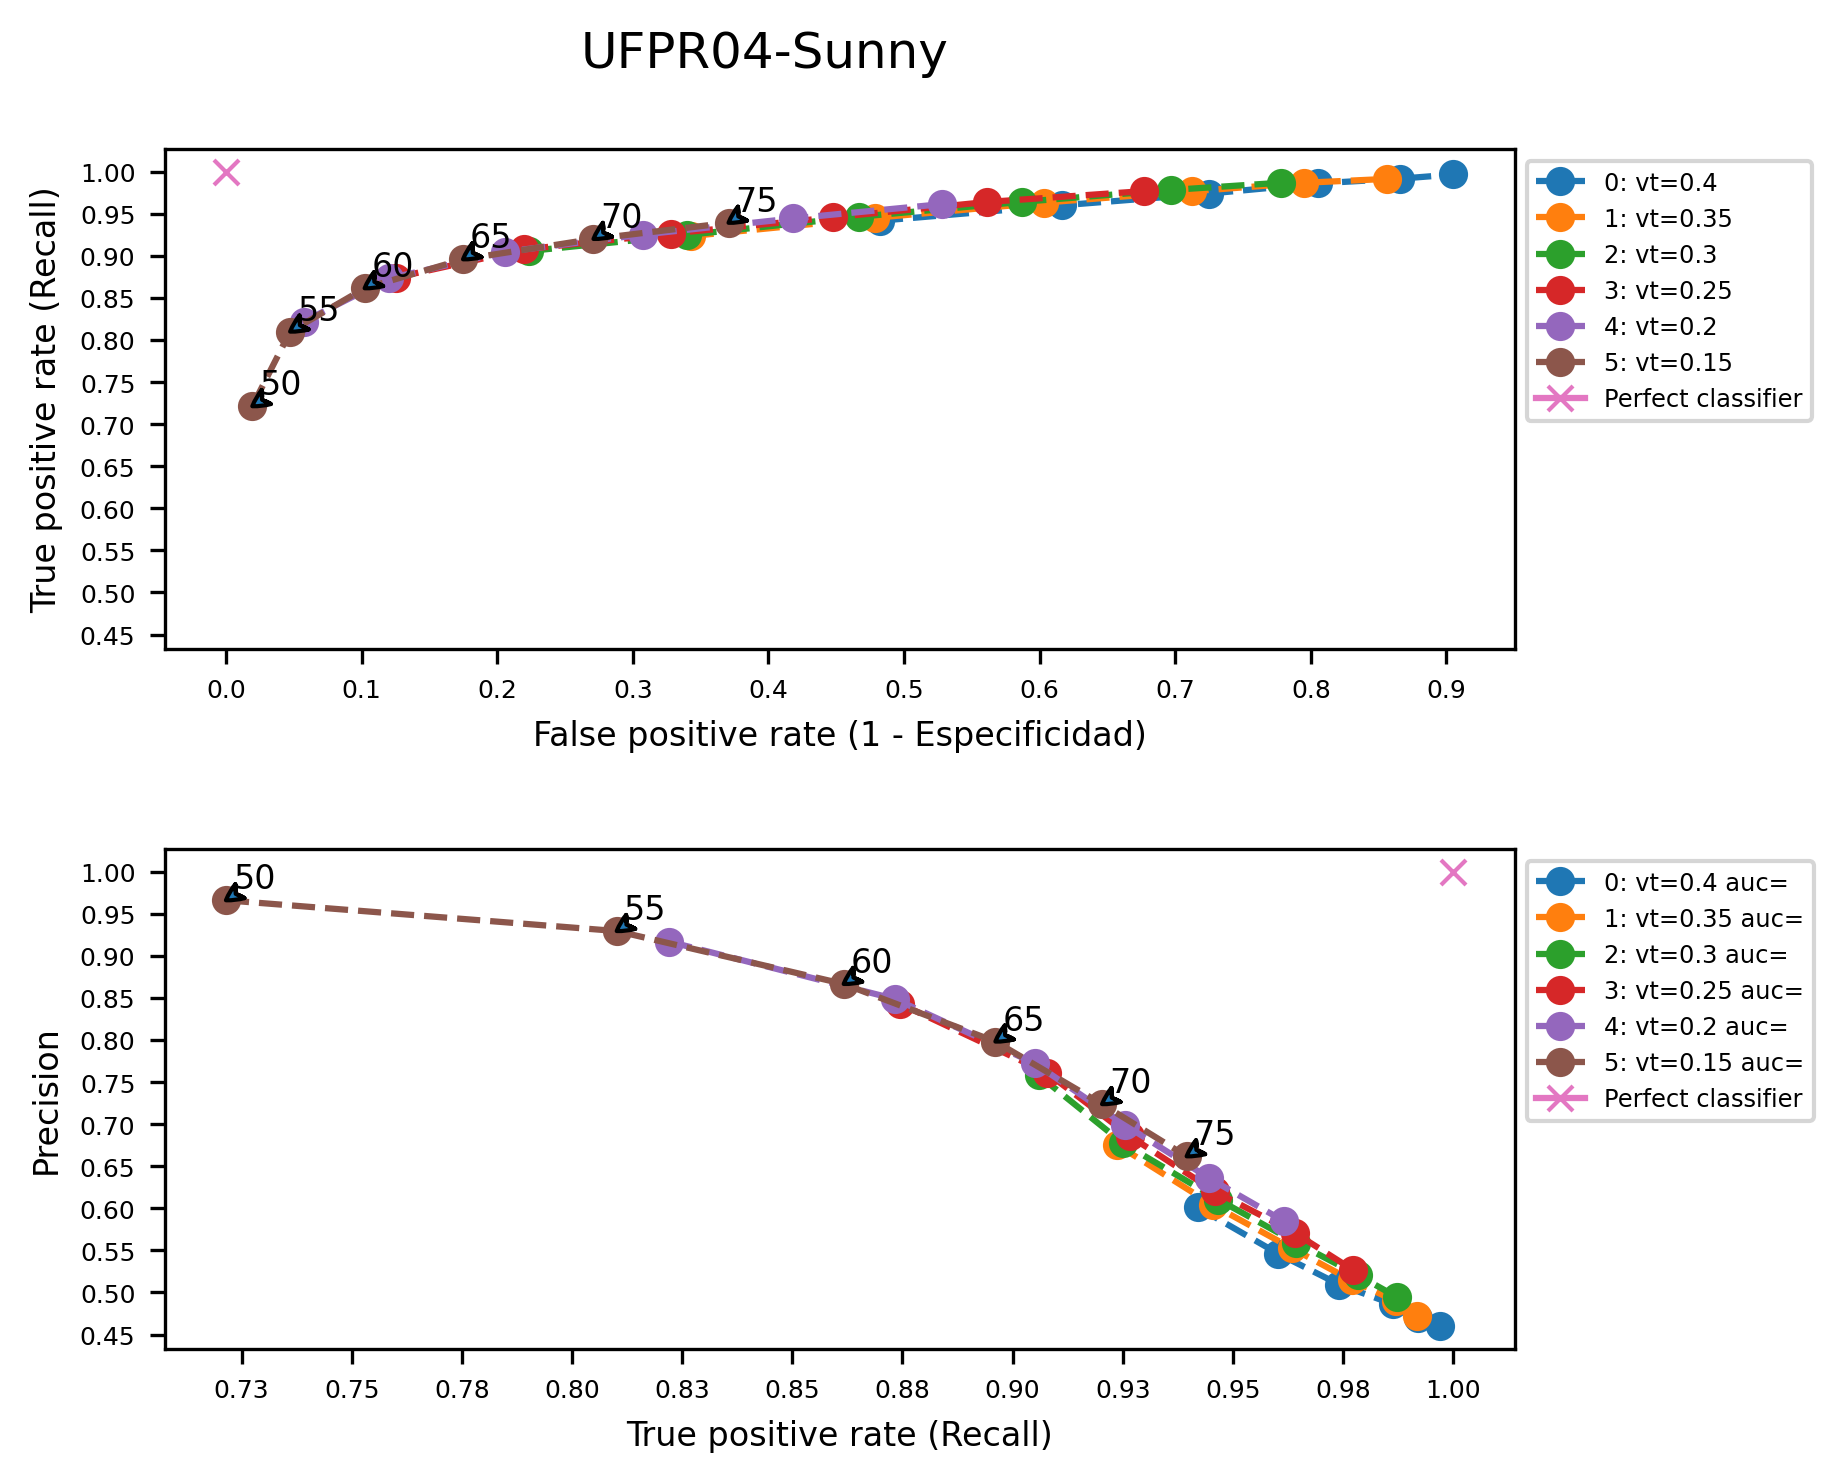

test/metrics/metrics_dict_vt_UFPR04_Cloudy_training.pickle


EOFError: Ran out of input

In [3]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=False)  # UFPR04
vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
diff_threshold_list = [50,55,60,65,70,75]
parking_id = 'UFPR04'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'

calculate_metrics(parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training=training, show_metrics=True, save_fig_dst=save_dst)

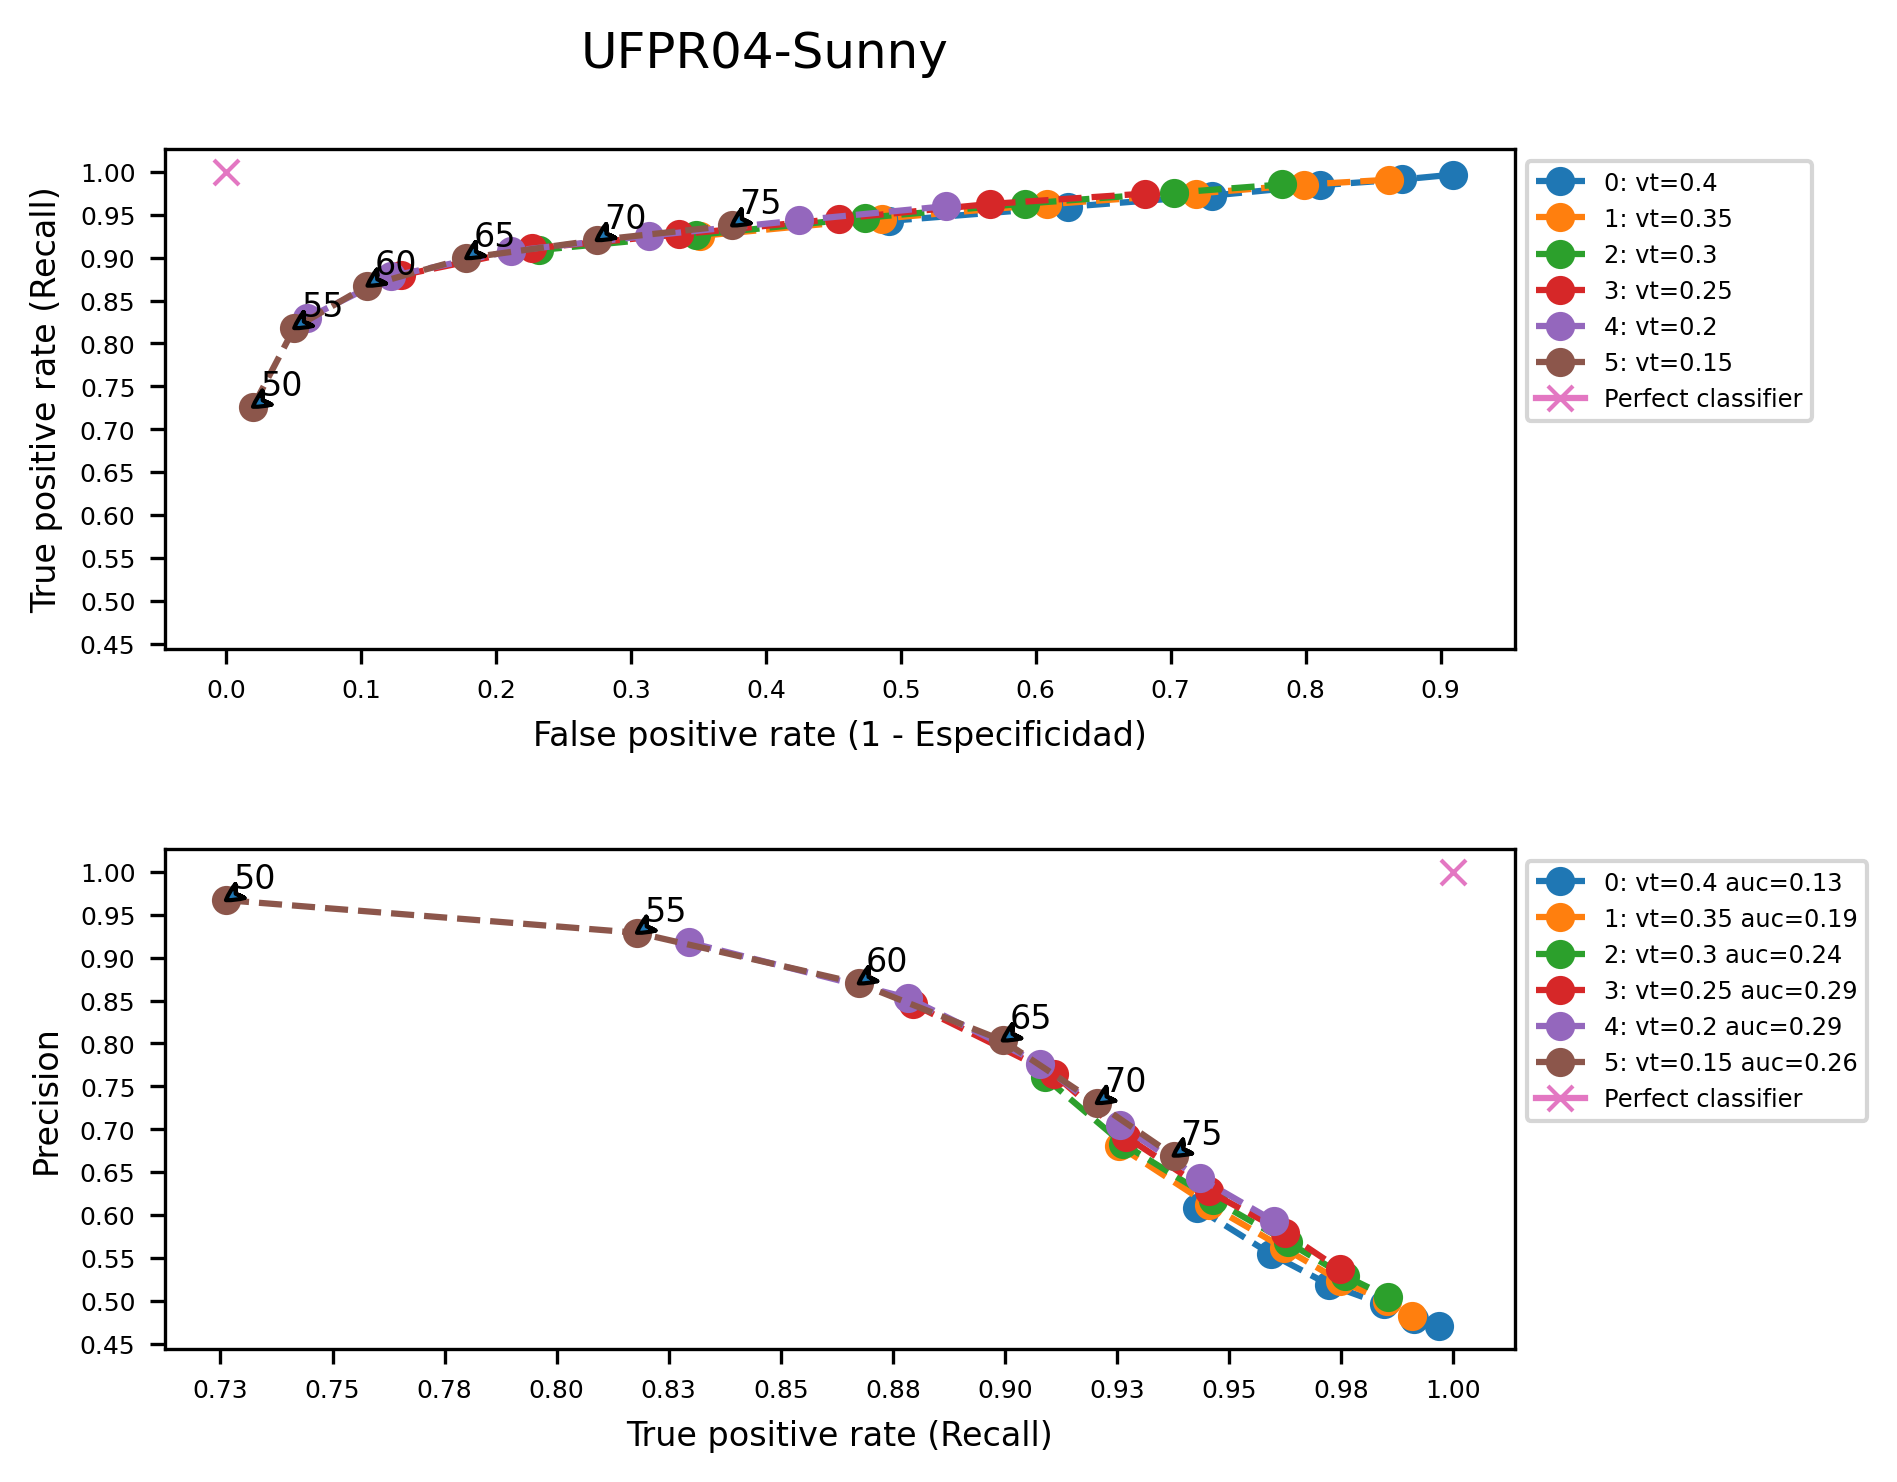

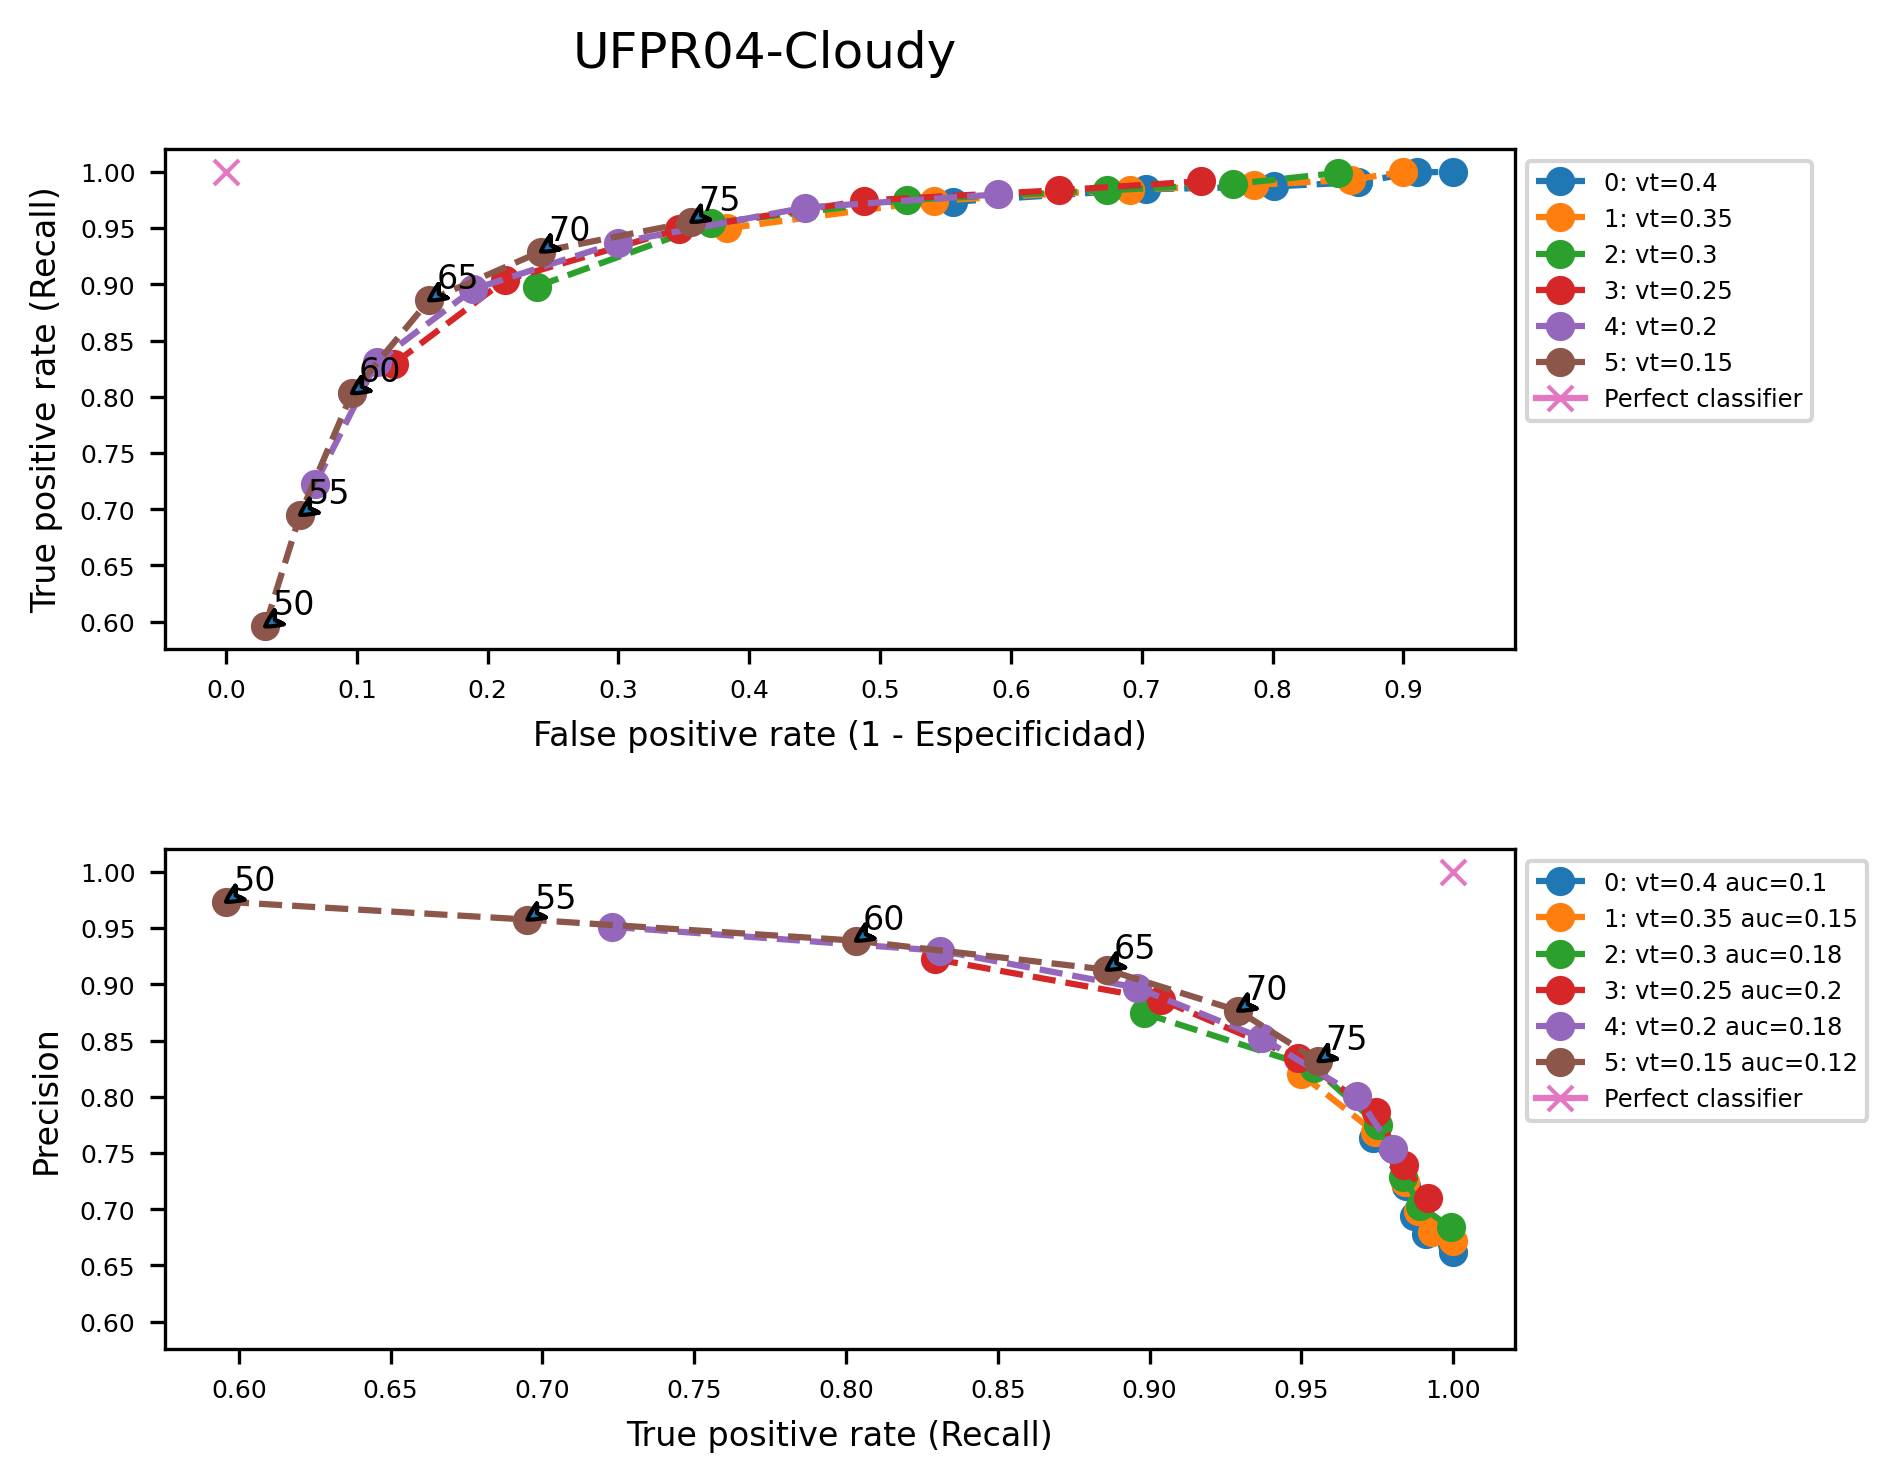

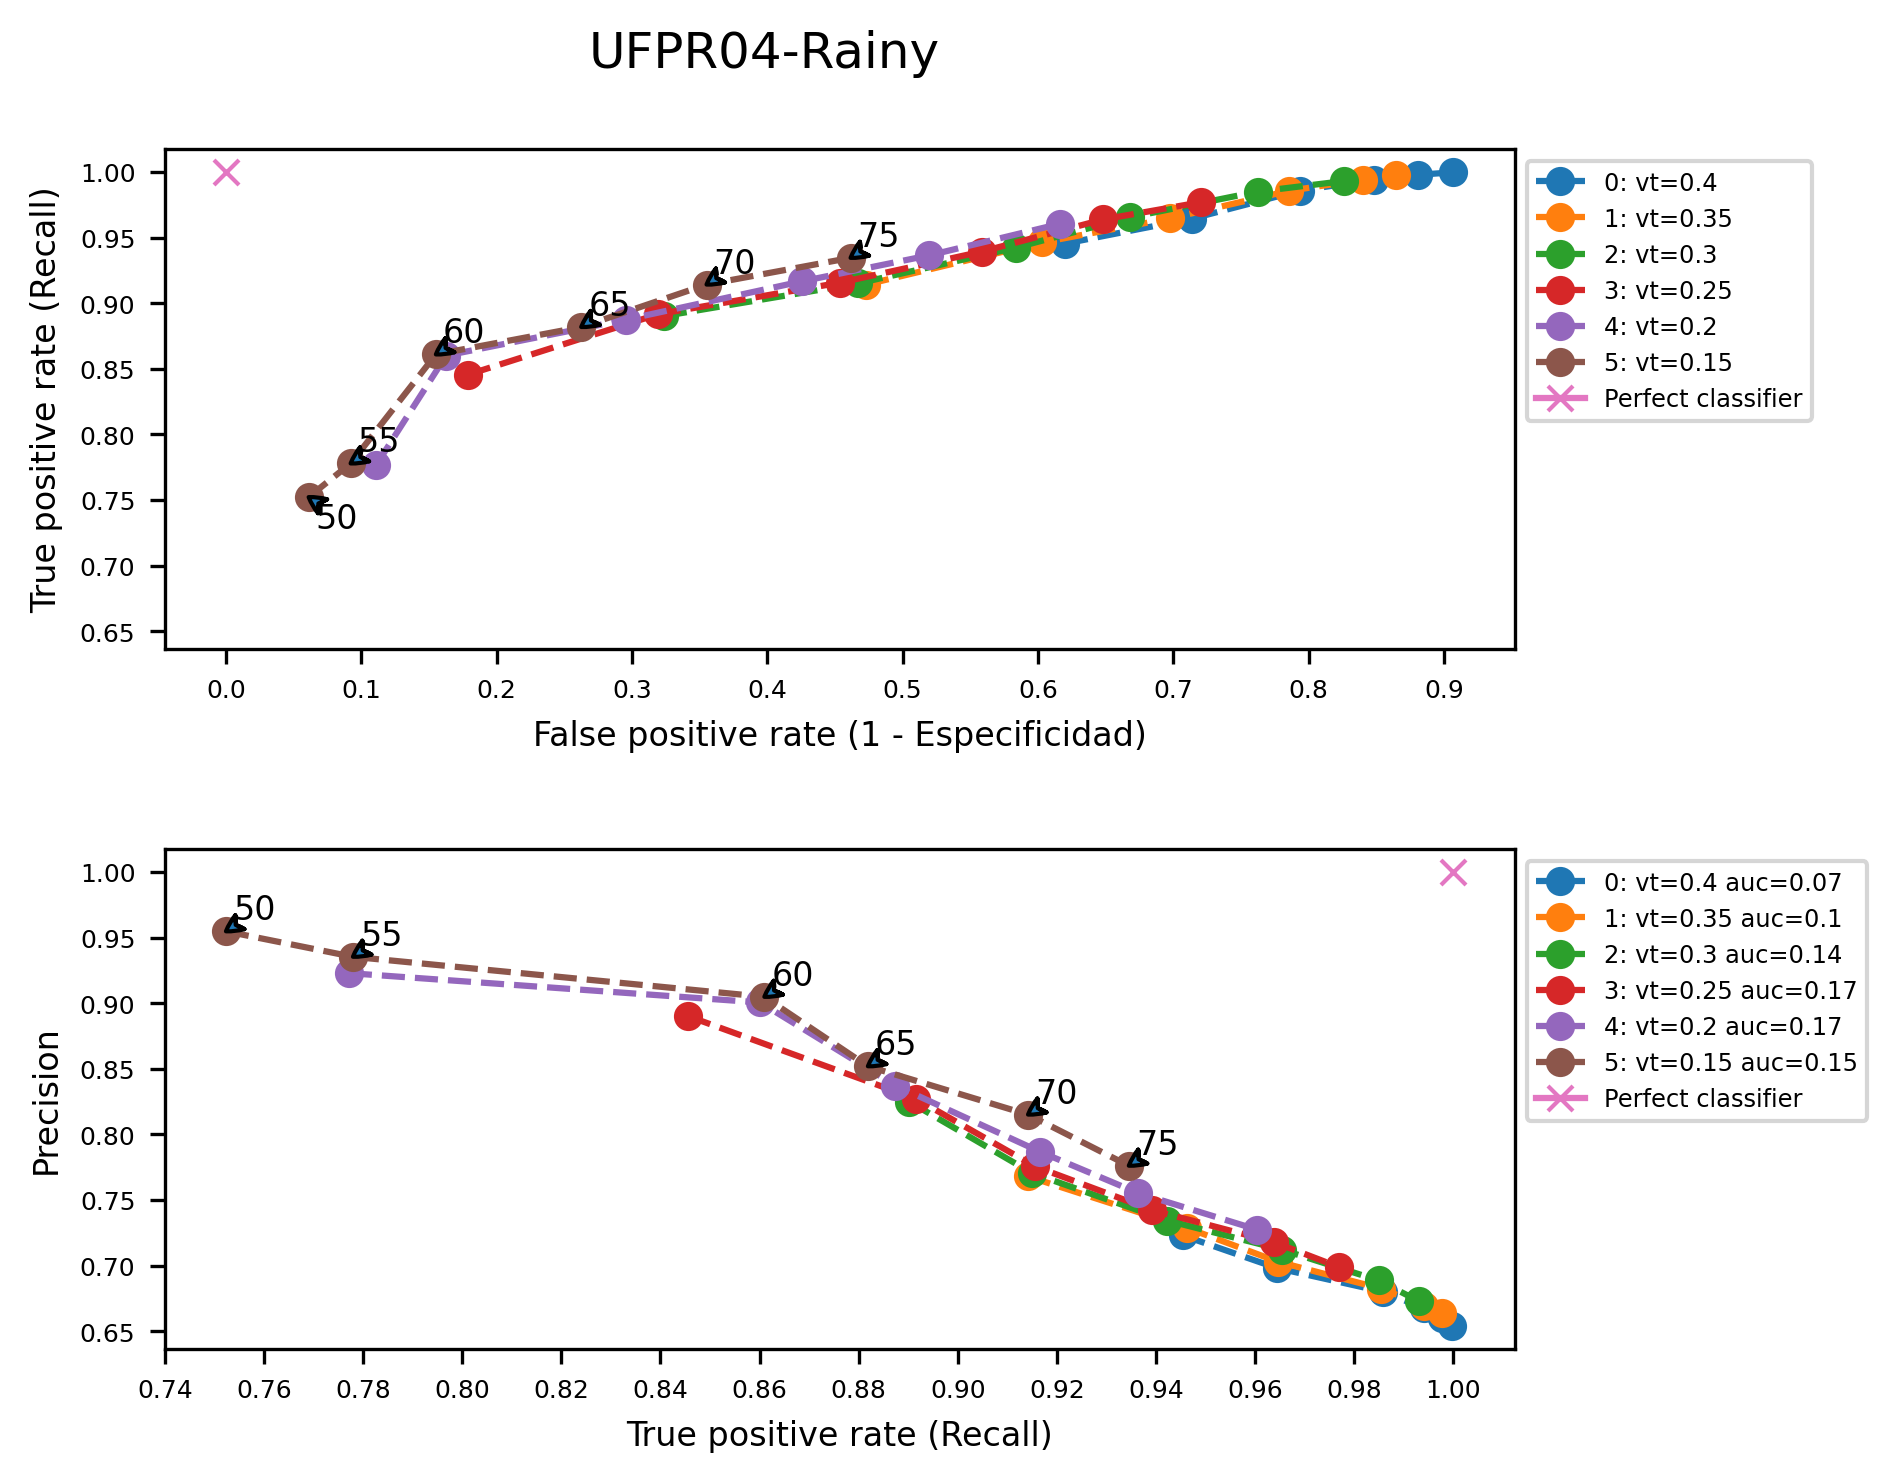

In [2]:
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=False)  # UFPR04
vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
diff_threshold_list = [50,55,60,65,70,75]
parking_id = 'UFPR04'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'

calculate_metrics(parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training=training, show_metrics=True, save_fig_dst=save_dst)

## UFPR04 Testing

UFPR04-Sunny Testing
Processing 420 files with 8 workers


100%|██████████| 420/420 [00:16<00:00, 26.13it/s]


Precision: 0.853
specificity: 0.876
Recall: 0.873
F1 Score: 0.863
Accuracy: 0.874


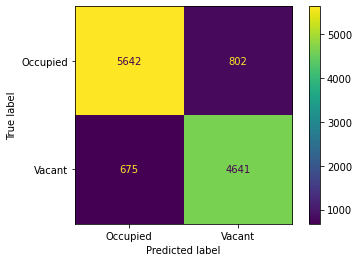

UFPR04-Cloudy Testing
Processing 282 files with 8 workers


100%|██████████| 282/282 [00:12<00:00, 22.67it/s]

Precision: 0.923
specificity: 0.877
Recall: 0.828
F1 Score: 0.873
Accuracy: 0.846


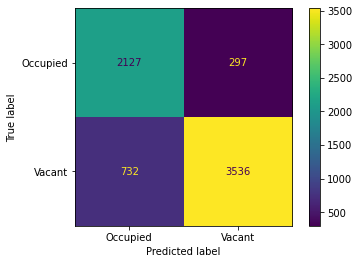

UFPR04-Rainy Testing
Processing 57 files with 8 workers


100%|██████████| 57/57 [00:04<00:00, 13.80it/s]

Precision: 0.951
specificity: 0.850
Recall: 0.838
F1 Score: 0.891
Accuracy: 0.841


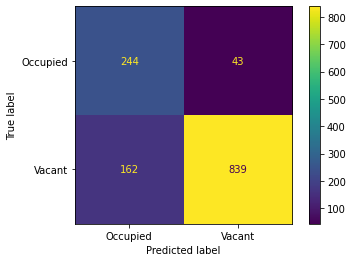

In [14]:
parking_id = 'UFPR04'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
detection_params=DetectionParams()
detection_params.diff_threshold = 55
detection_params.vacant_threshold = 0.2
detection_params.match_histograms = True

weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=True, training=training)

# UFPR05

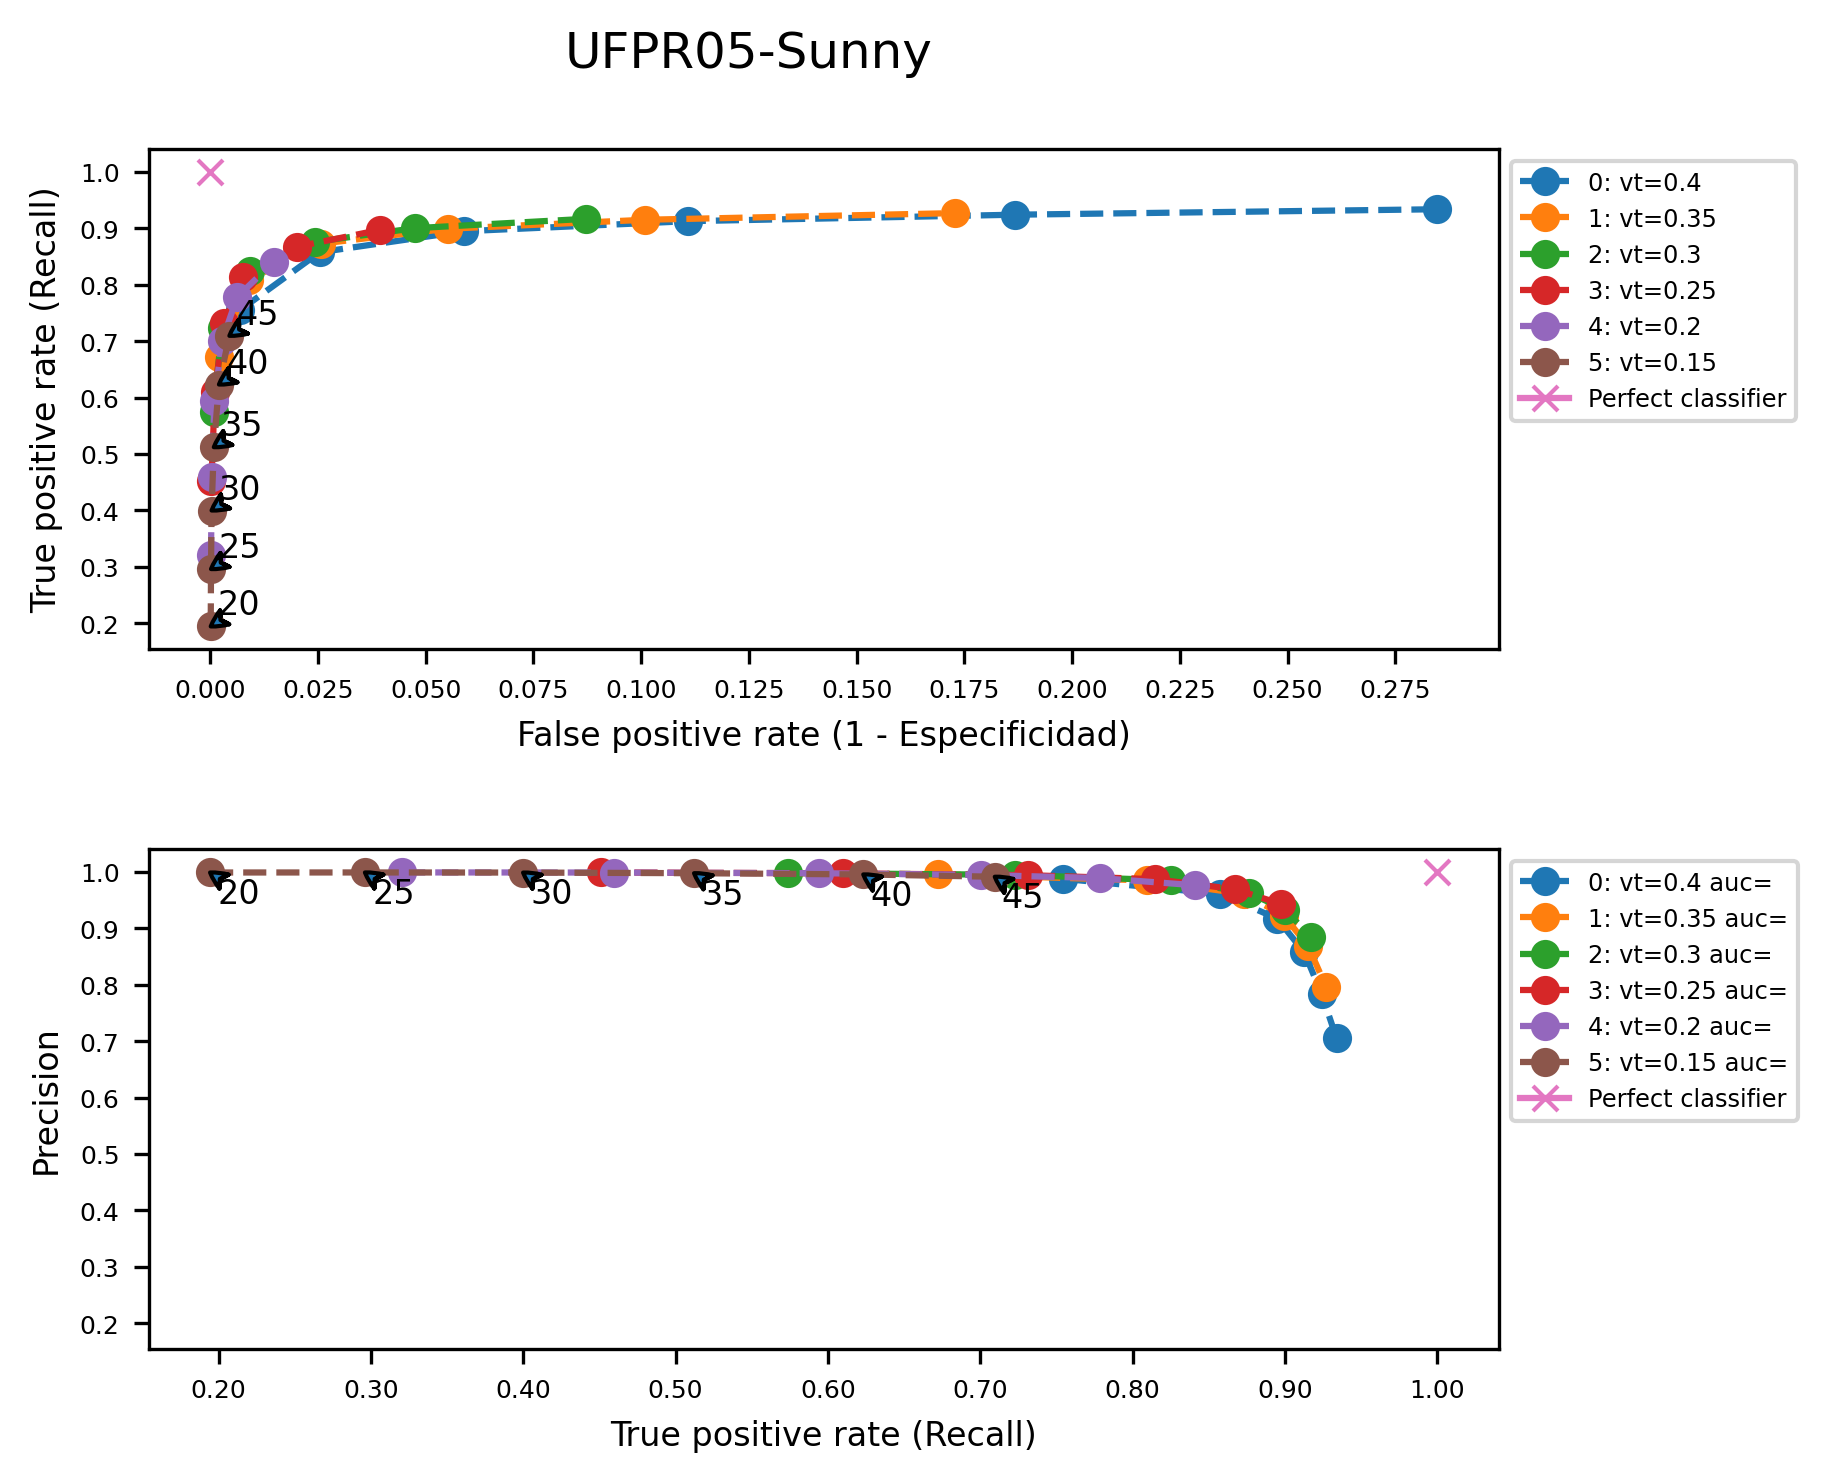

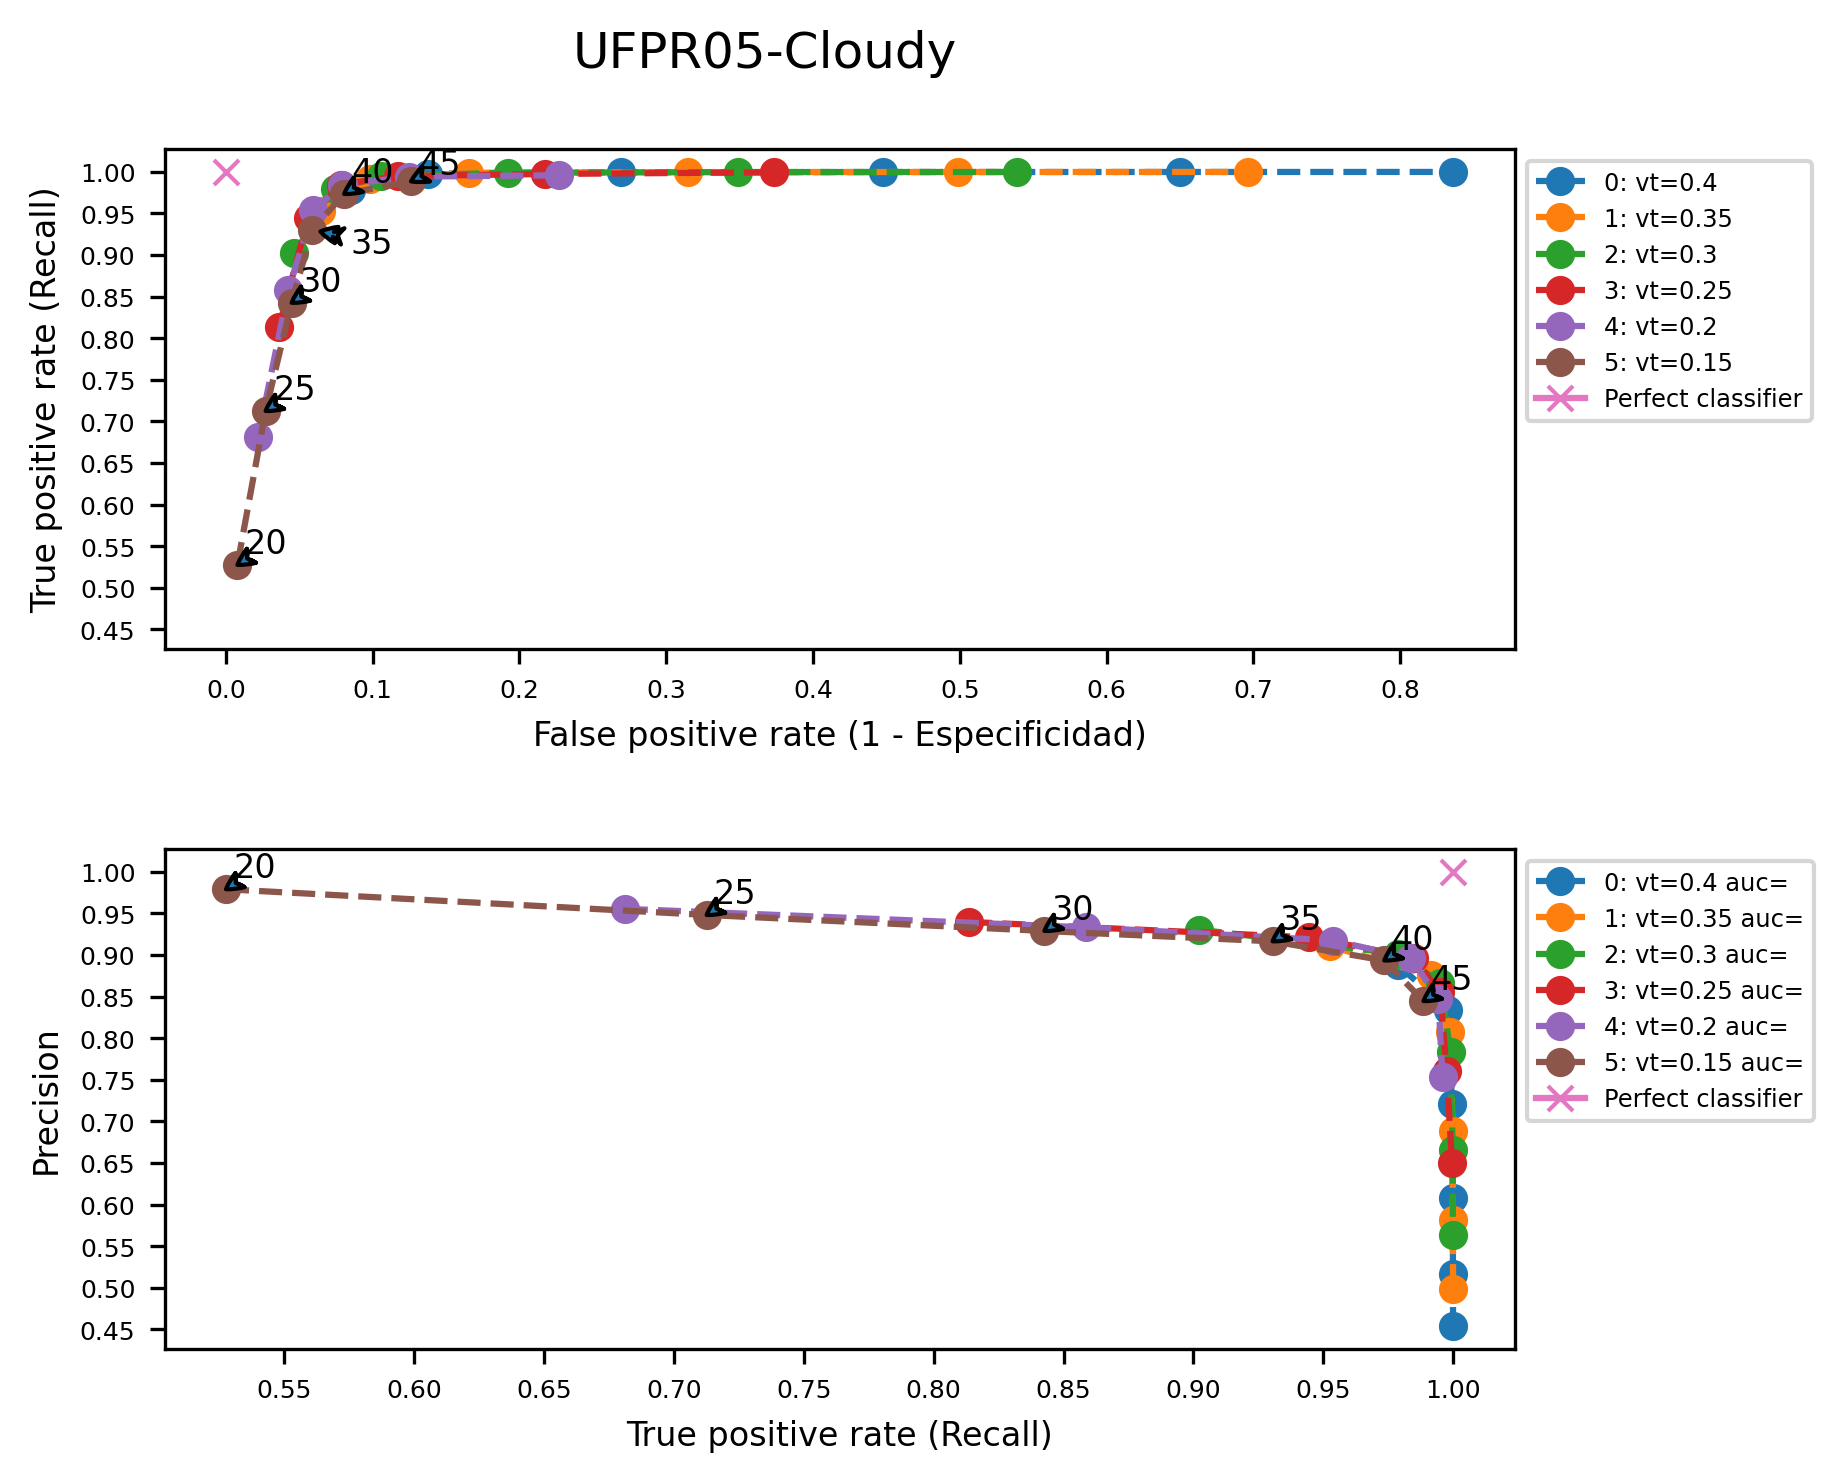

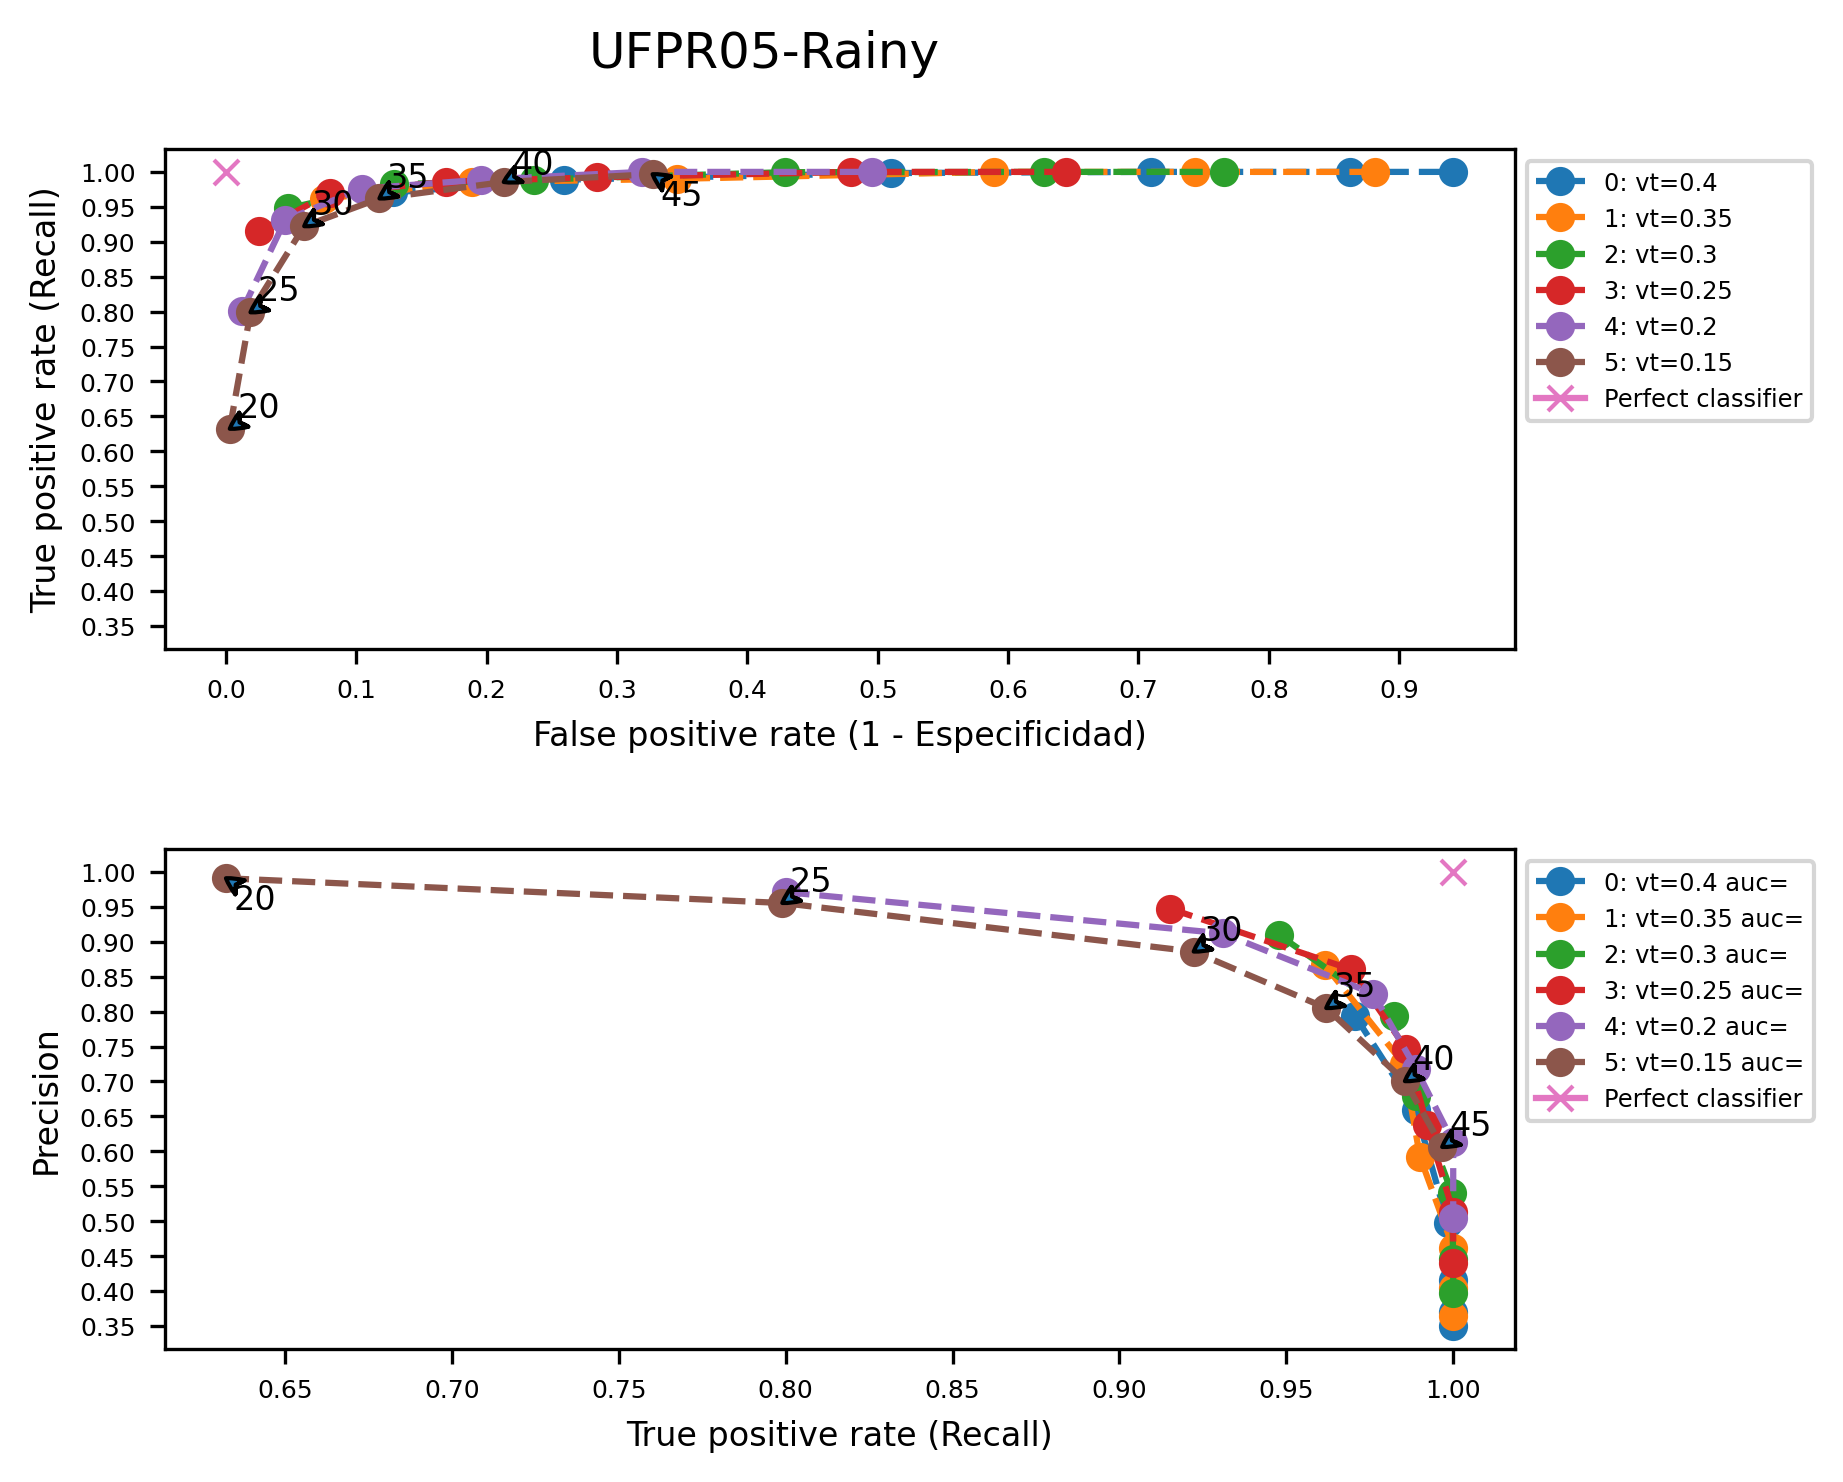

In [3]:
import pickle
PARAMS_UFPR05 = DetectionParams(gb_k=(3,3), gb_s=0, median_k=3, bw_size=20, show_imshow=False)
PARAMS_PUCPR = DetectionParams(gb_k=(5, 5), gb_s=0, median_k=3, bw_size=85, show_imshow=False)
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=False)

vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
diff_threshold_list = [20,25,30,35,40,45]
parking_id = 'UFPR05'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'

calculate_metrics(parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training=training, show_metrics=True, save_fig_dst=save_dst)

## UFPR05 Testing

UFPR05-Sunny Testing
Processing 500 files with 8 workers


100%|██████████| 500/500 [00:18<00:00, 26.50it/s]


Precision: 0.966
specificity: 0.977
Recall: 0.865
F1 Score: 0.912
Accuracy: 0.929


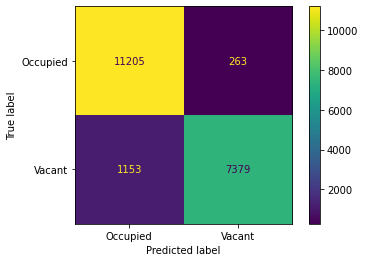

UFPR05-Cloudy Testing
Processing 286 files with 8 workers


100%|██████████| 286/286 [00:11<00:00, 25.13it/s]


Precision: 0.752
specificity: 0.784
Recall: 0.996
F1 Score: 0.857
Accuracy: 0.868


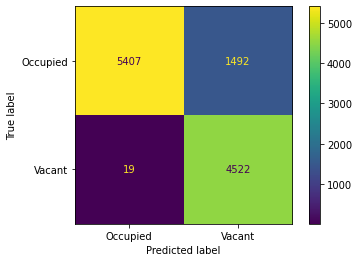

UFPR05-Rainy Testing
Processing 46 files with 8 workers


100%|██████████| 46/46 [00:03<00:00, 12.85it/s]


Precision: 0.390
specificity: 0.520
Recall: 1.000
F1 Score: 0.562
Accuracy: 0.633


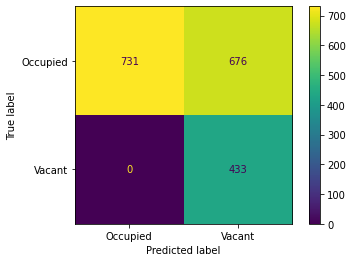

In [4]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
detection_params=DetectionParams()
detection_params.diff_threshold = 40
detection_params.vacant_threshold = 0.25
detection_params.match_histograms = True

weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=True, training=training)

UFPR05-Sunny Testing
Processing 500 files with 8 workers


100%|██████████| 500/500 [00:18<00:00, 26.86it/s]


Precision: 0.966
specificity: 0.977
Recall: 0.865
F1 Score: 0.912
Accuracy: 0.929


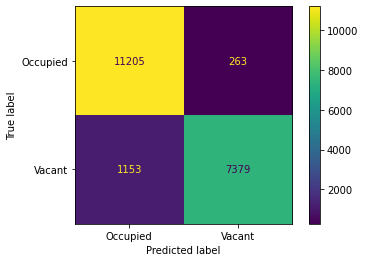

In [9]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
detection_params=DetectionParams()
detection_params.diff_threshold = 40
detection_params.vacant_threshold = 0.25
detection_params.match_histograms = True

weather_list = ['Sunny']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=True, training=training)

UFPR05-Cloudy Testing
Processing 286 files with 8 workers


100%|██████████| 286/286 [00:11<00:00, 25.02it/s]


Precision: 0.910
specificity: 0.939
Recall: 0.927
F1 Score: 0.918
Accuracy: 0.934


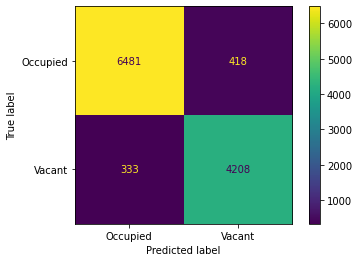

In [10]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
detection_params=DetectionParams()
detection_params.diff_threshold = 35
detection_params.vacant_threshold = 0.15
detection_params.match_histograms = True

weather_list = ['Cloudy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=True, training=training)

UFPR05-Rainy Testing
Processing 46 files with 8 workers


100%|██████████| 46/46 [00:03<00:00, 12.89it/s]

Precision: 0.800
specificity: 0.929
Recall: 0.924
F1 Score: 0.857
Accuracy: 0.928


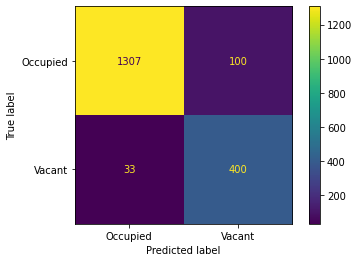

In [12]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
detection_params=DetectionParams()
detection_params.diff_threshold = 30
detection_params.vacant_threshold = 0.15
detection_params.match_histograms = True

weather_list = ['Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=True, training=training)

# PUCPR

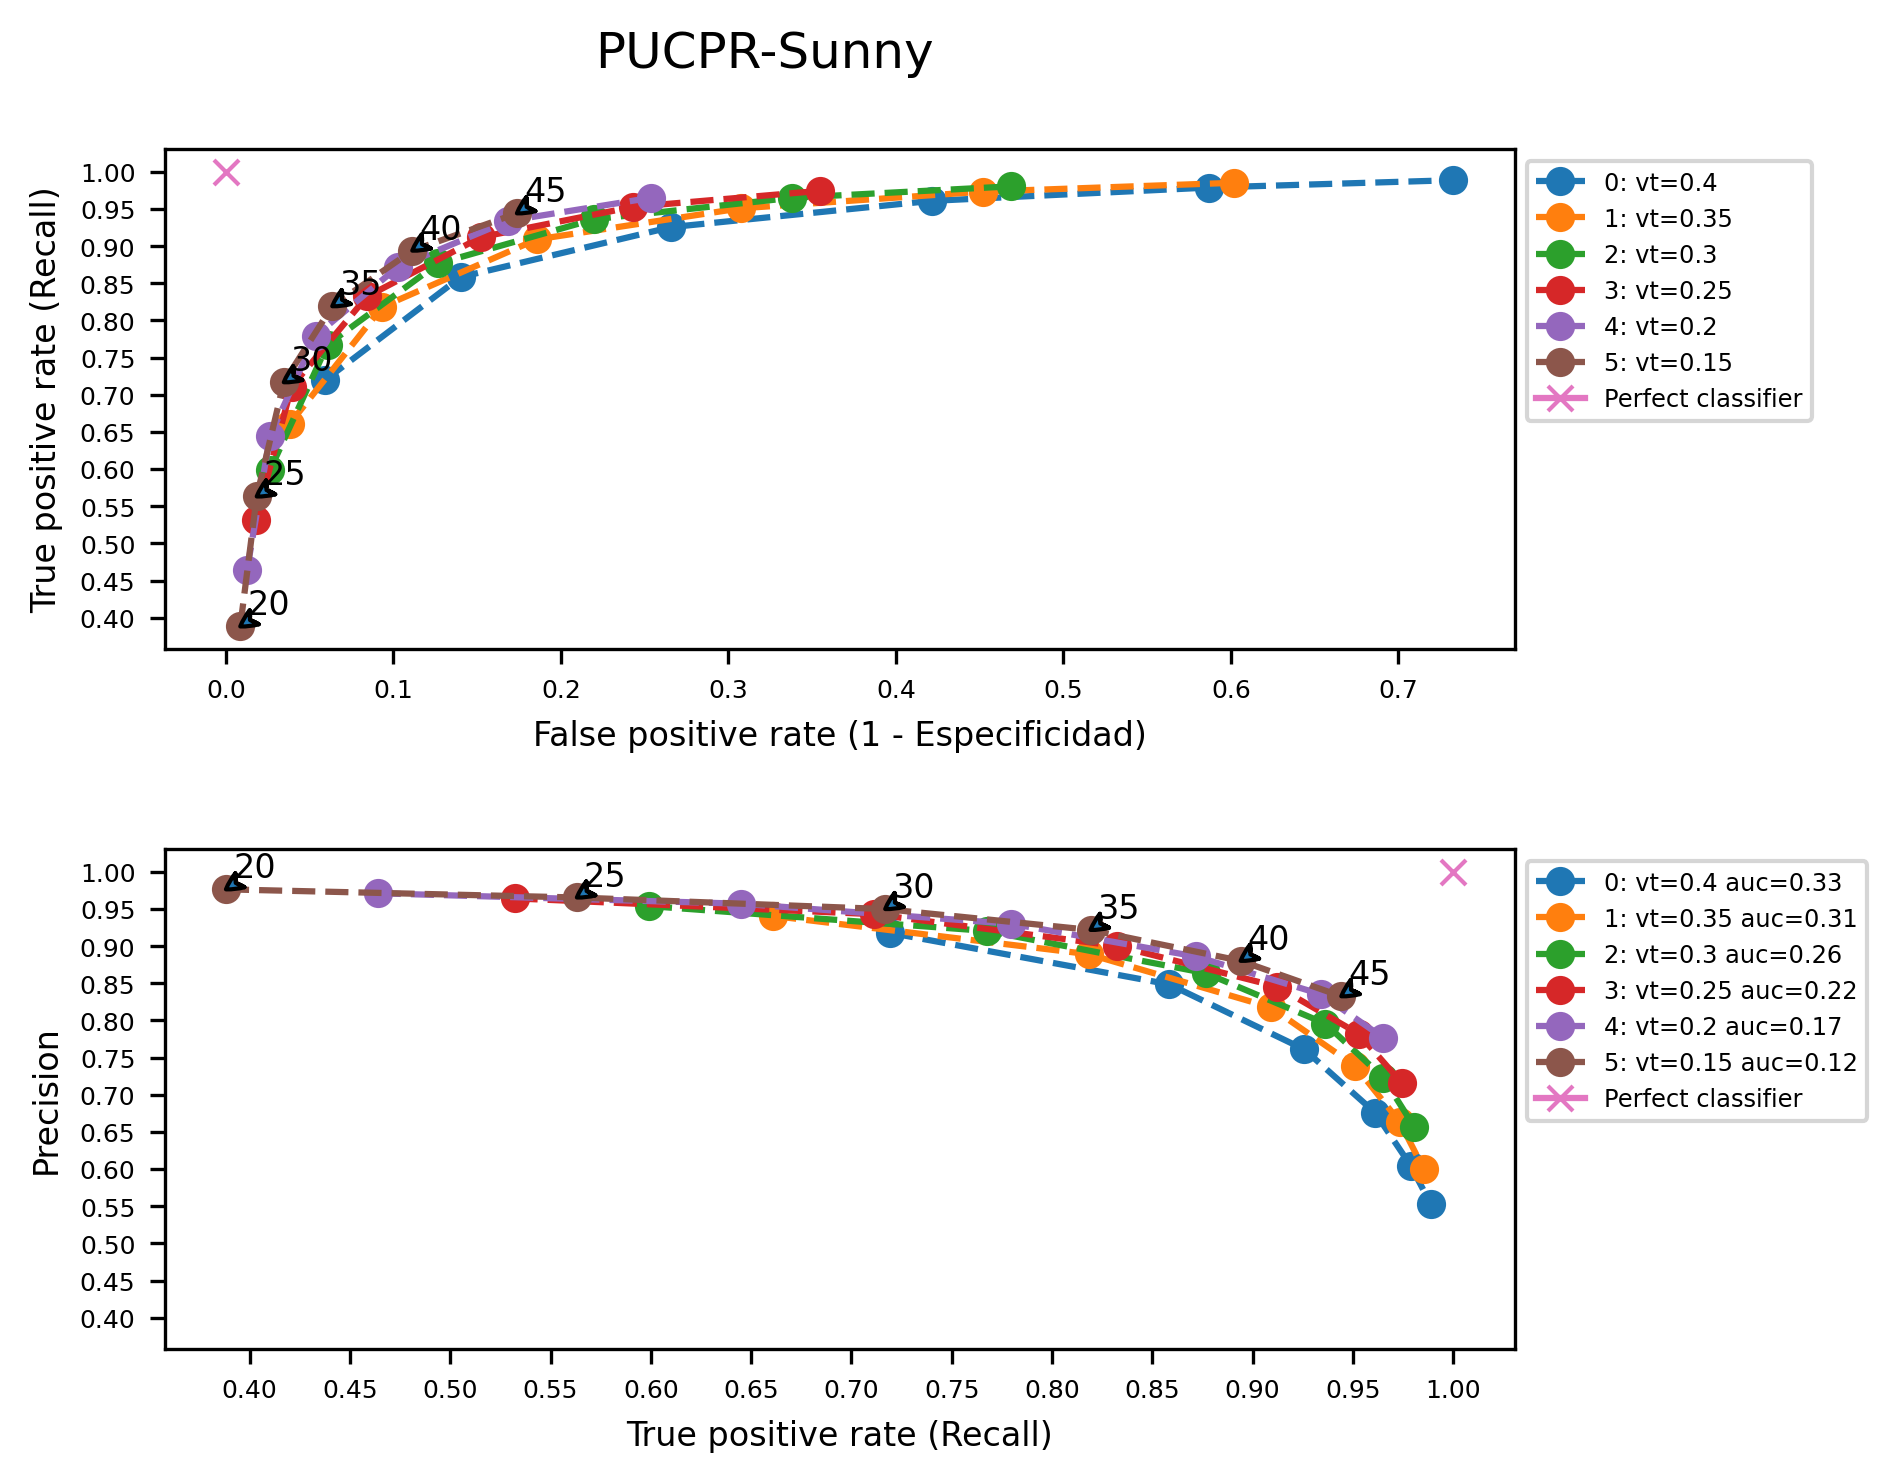

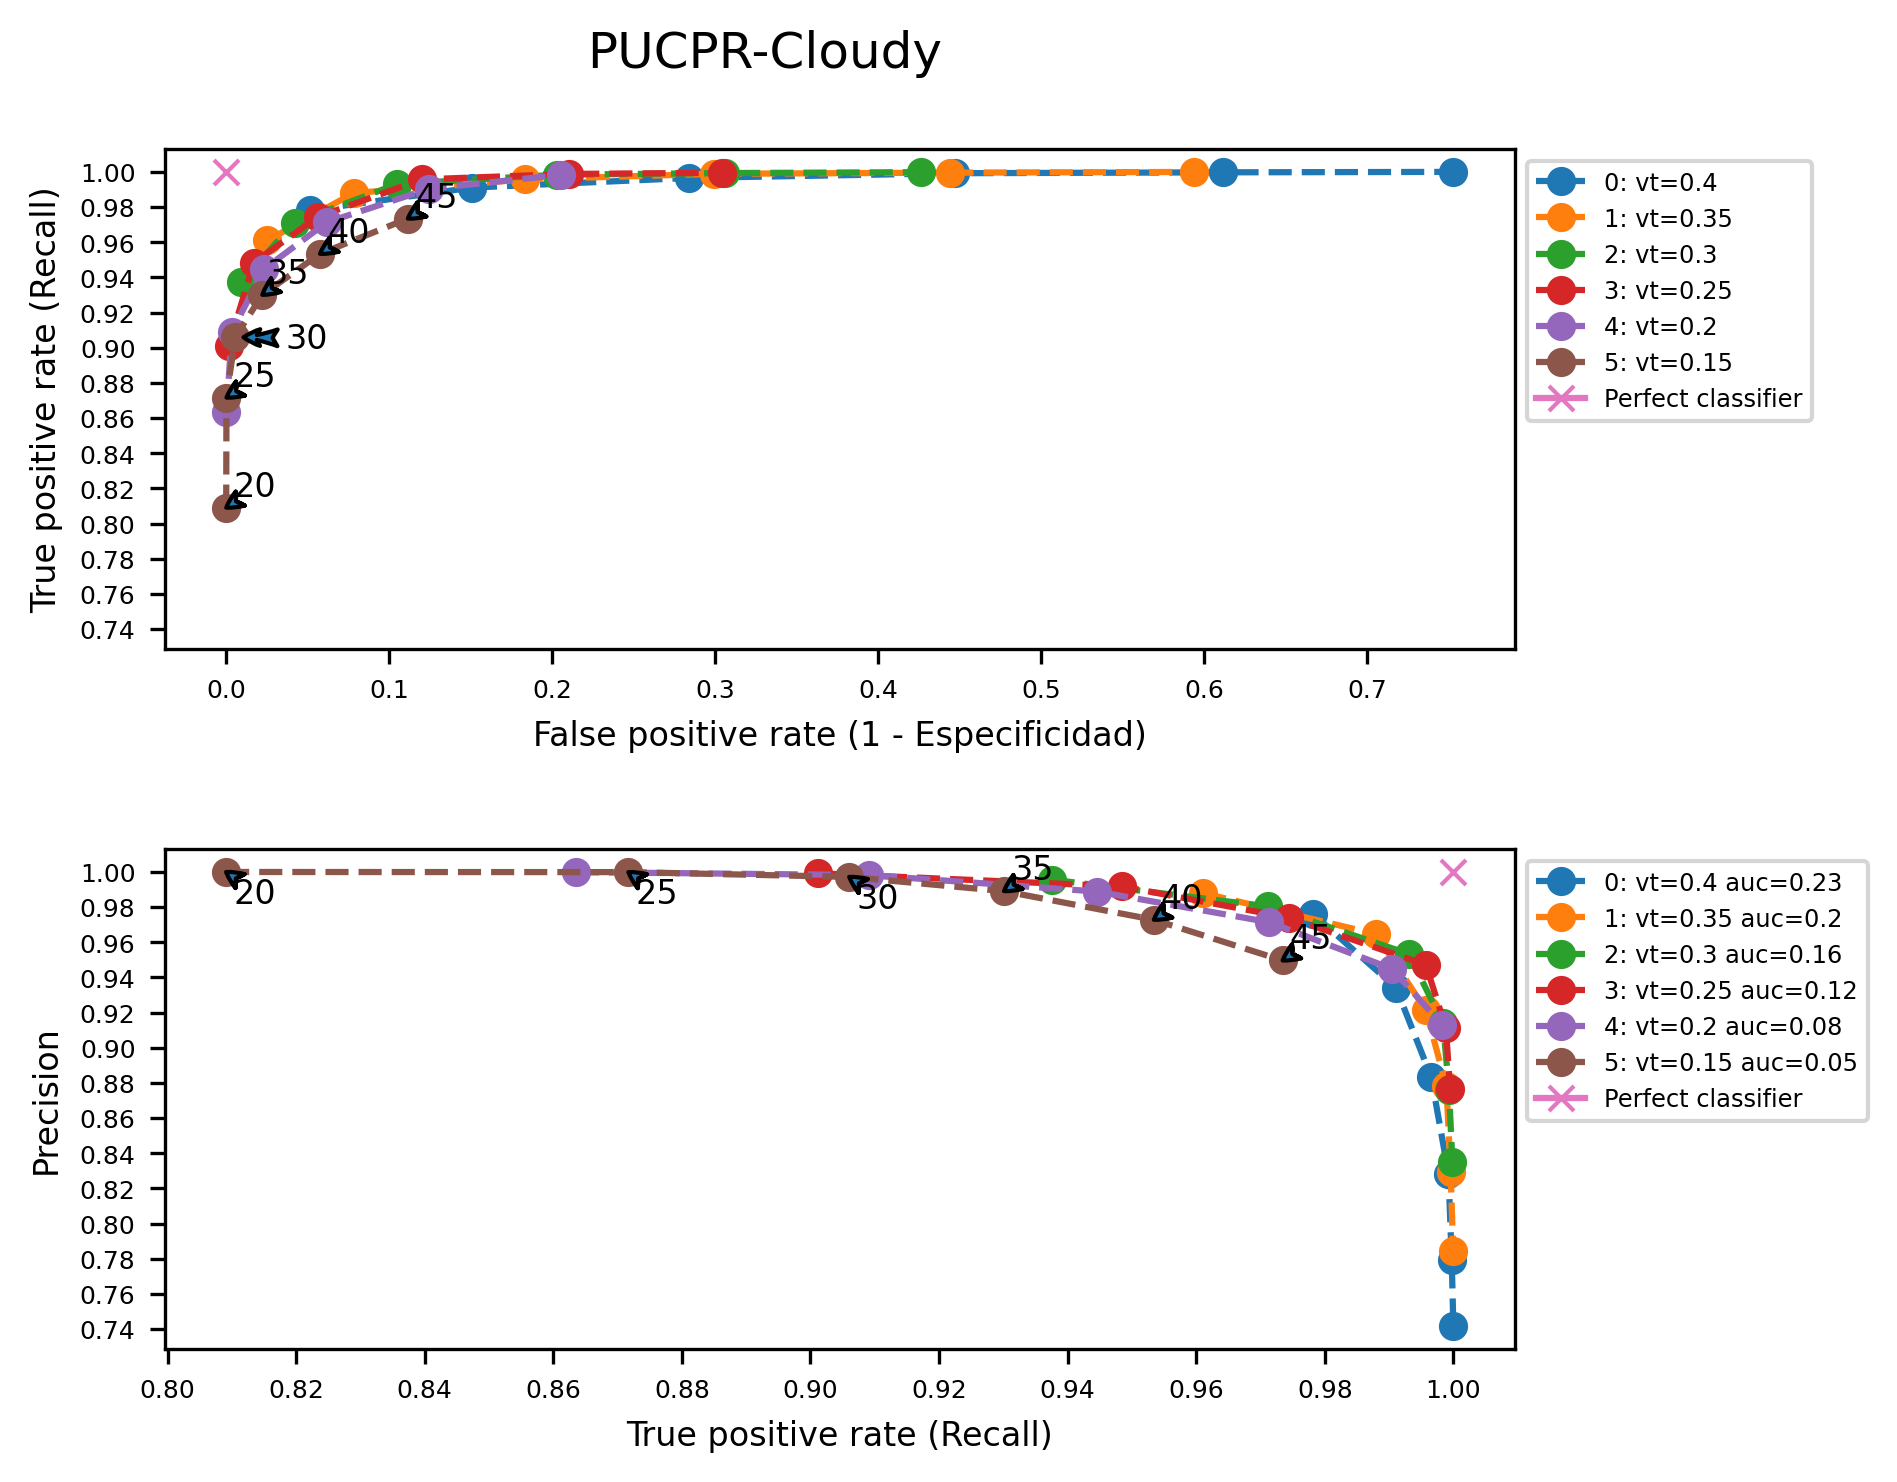

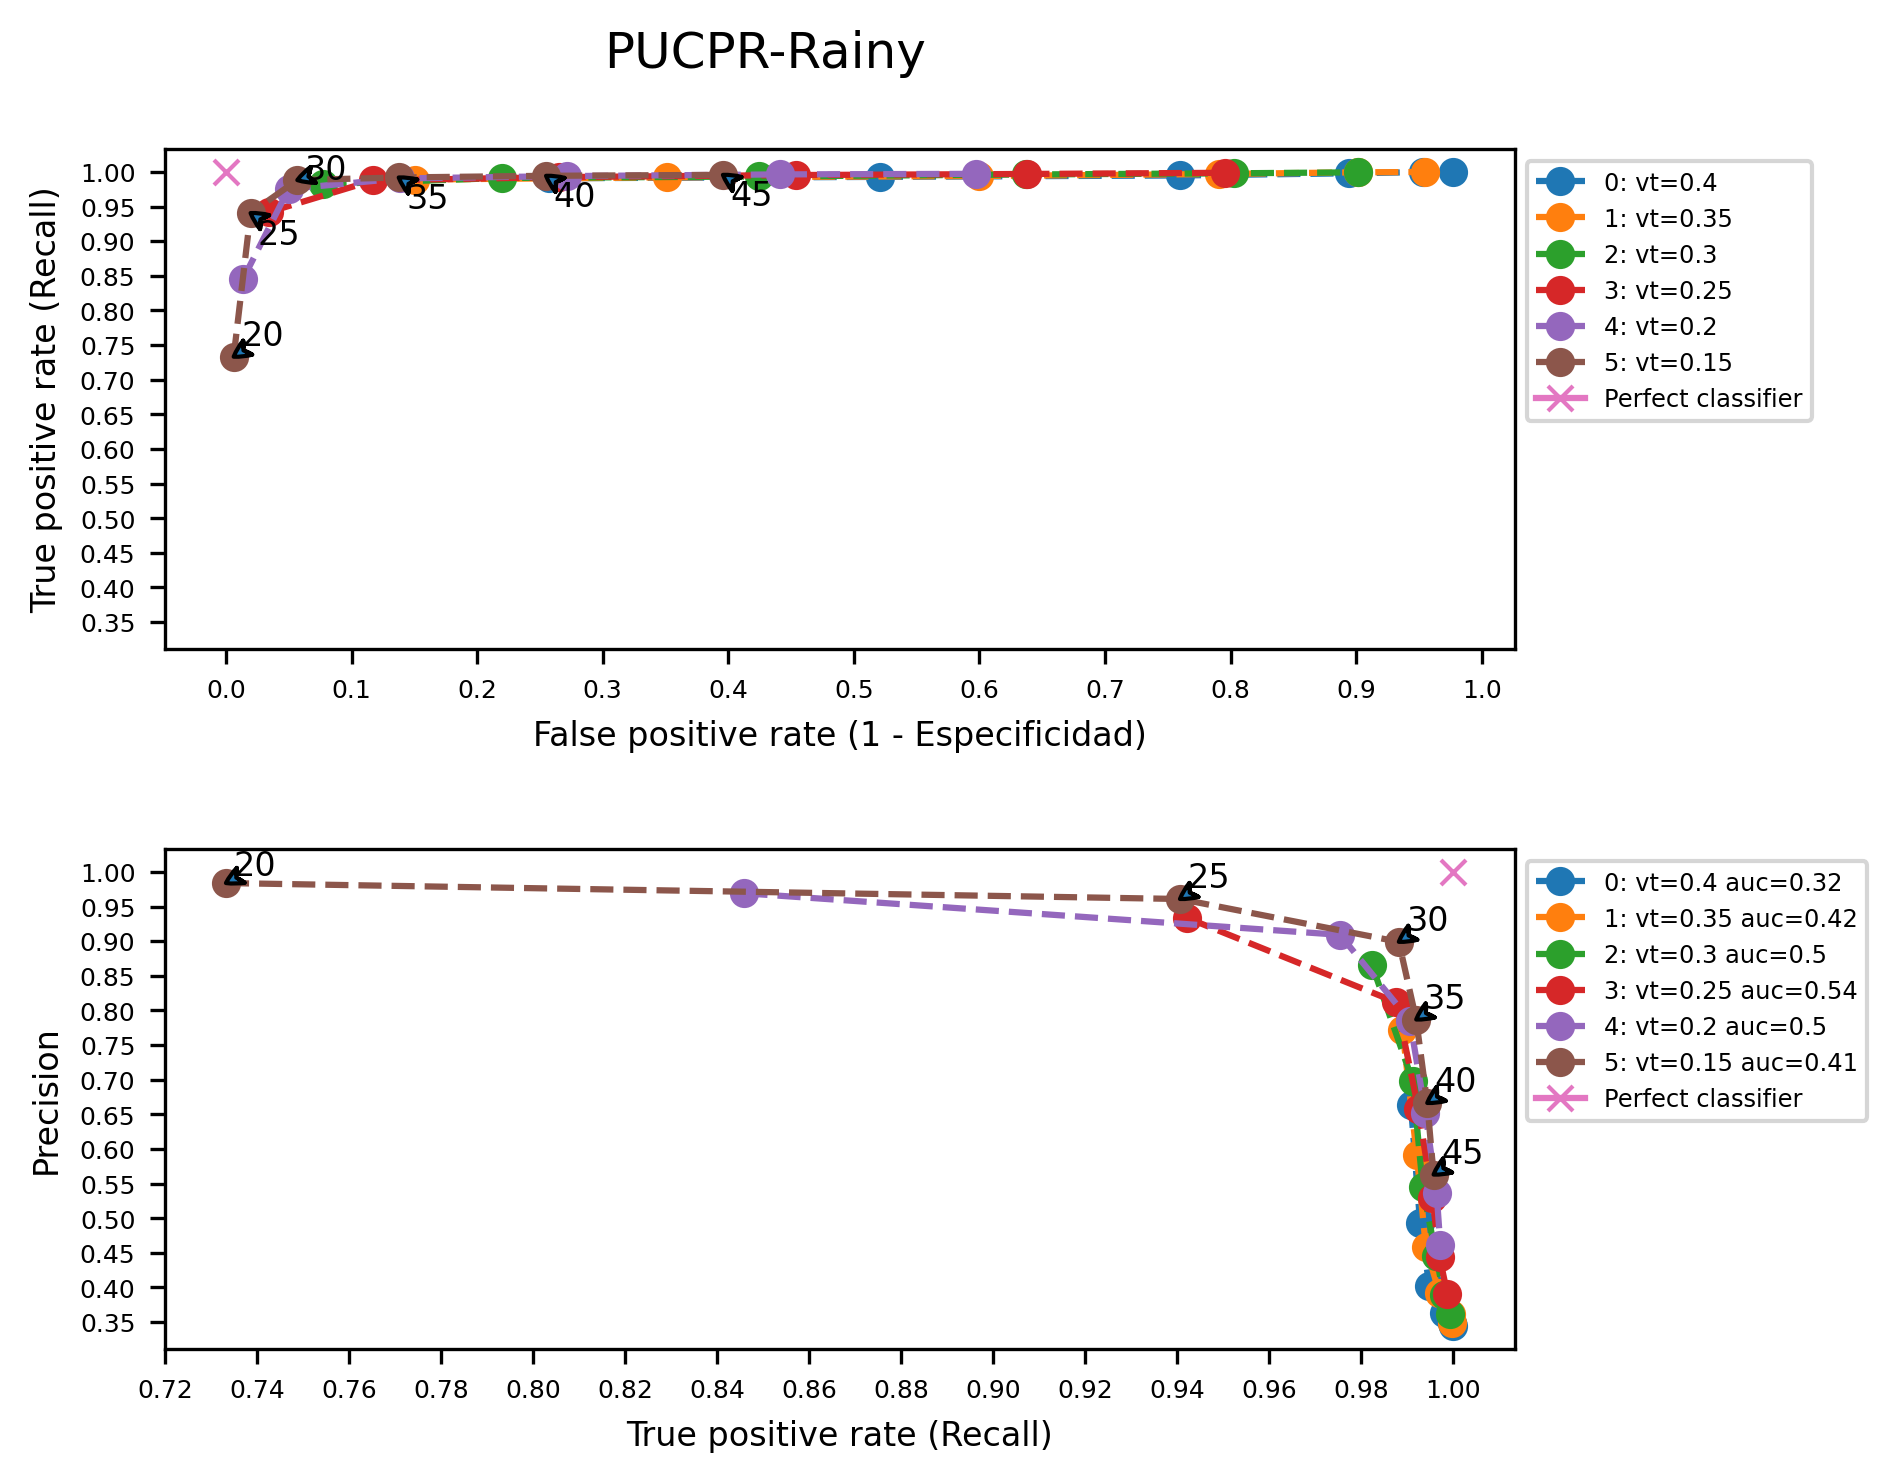

In [20]:
import pickle
PARAMS_UFPR05 = DetectionParams(gb_k=(3,3), gb_s=0, median_k=3, bw_size=20, show_imshow=False)
PARAMS_PUCPR = DetectionParams(gb_k=(5, 5), gb_s=0, median_k=3, bw_size=85, show_imshow=False)
PARAMS_UFPR04 = DetectionParams(gb_k=(3, 3), gb_s=0, median_k=5, bw_size=26, show_imshow=False)

vacant_threshold_list = [0.4, 0.35, 0.30, 0.25, 0.2, 0.15]
diff_threshold_list = [20,25,30,35,40,45]
parking_id = 'PUCPR'
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'

calculate_metrics(parking_id, weather_list, diff_threshold_list, vacant_threshold_list, training=training, show_metrics=True, save_fig_dst=save_dst)

## PUCPR Testing

PUCPR-Sunny Testing
Processing 463 files with 8 workers


100%|██████████| 463/463 [00:18<00:00, 25.52it/s]


Precision: 0.937
specificity: 0.953
Recall: 0.700
F1 Score: 0.801
Accuracy: 0.827


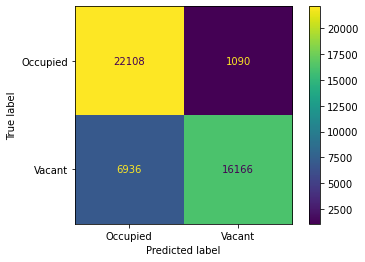

PUCPR-Cloudy Testing
Processing 266 files with 8 workers


100%|██████████| 266/266 [00:10<00:00, 24.27it/s]


Precision: 0.997
specificity: 0.994
Recall: 0.906
F1 Score: 0.949
Accuracy: 0.935


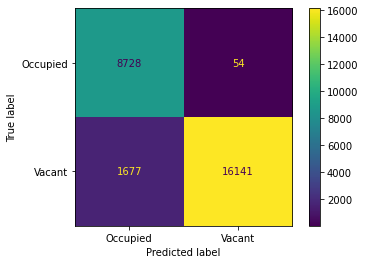

PUCPR-Rainy Testing
Processing 167 files with 8 workers


100%|██████████| 167/167 [00:07<00:00, 21.50it/s]


Precision: 0.896
specificity: 0.944
Recall: 0.985
F1 Score: 0.938
Accuracy: 0.958


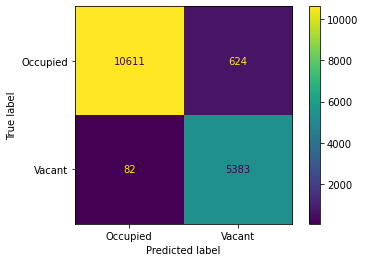

In [19]:
parking_id = 'PUCPR'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\metrics\\'
detection_params=DetectionParams()
detection_params.diff_threshold = 30
detection_params.vacant_threshold = 0.15
detection_params.match_histograms = True

weather_list = ['Sunny', 'Cloudy', 'Rainy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, row_name=row_name, process_batch=True, training=training)

No of Channel is: 3
No of Channel is: 2
No of Channel is: 3


C:\Users\VCTOR~1\AppData\Local\Temp/ipykernel_23804/3905844770.py:26: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = match_histograms(image, reference ,multichannel=True)
C:\Users\VCTOR~1\AppData\Local\Temp/ipykernel_23804/3905844770.py:27: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched_gray = match_histograms(img1_gray, img2_gray,multichannel=True)


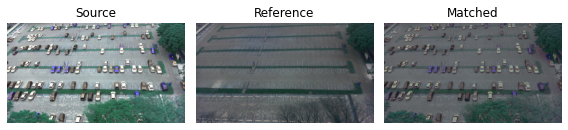

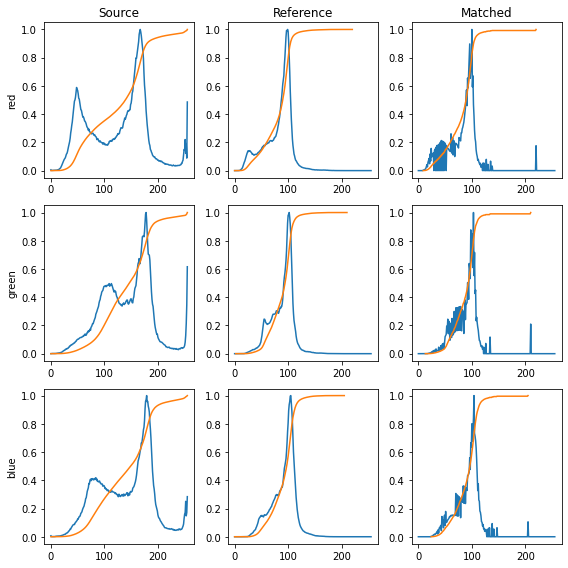

-1

In [8]:
# import packages
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.exposure import match_histograms
import cv2
  
# reading main image
img1 = cv2.imread("dataset\PUCPR_rainy.jpg")
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  
# checking the number of channels
print('No of Channel is: ' + str(img1.ndim))
print('No of Channel is: ' + str(img1_gray.ndim))

  
# reading reference image
img2 =  cv2.imread("dataset\empty\PUCPR\Rainy\PUCPR_Rainy_empty.jpg")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
 
# checking the number of channels
print('No of Channel is: ' + str(img2.ndim))
  
image = img1
reference = img2
  
matched = match_histograms(image, reference ,multichannel=True)
matched_gray = match_histograms(img1_gray, img2_gray,multichannel=True)
matched_to_gray = cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)

# diff = cv2.absdiff(matched, reference)
# imgThreshold = cv2.threshold(
#     diff, 30, 255, cv2.THRESH_BINARY)[1]

# diff_blur = cv2.absdiff(matched_gray, img2_gray)
# imgThreshold_gray = cv2.threshold(
#     diff_blur, 30, 255, cv2.THRESH_BINARY)[1]

diff_blur_to_gray = cv2.absdiff(matched_to_gray, img2_gray)
imgThreshold_to_gray = cv2.threshold(
    diff_blur_to_gray, 30, 255, cv2.THRESH_BINARY)[1]
 

diff_blur_no_matching = cv2.absdiff(img1_gray, img2_gray)
imgThreshold_no_matching= cv2.threshold(
    diff_blur_no_matching, 60, 255, cv2.THRESH_BINARY)[1]
 
  
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, 
                                    figsize=(8, 3),
                                    sharex=True, sharey=True)
  
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()
  
ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

cv2.imshow('image',image)
cv2.imshow('reference', reference)
cv2.imshow('matched', matched)
cv2.imshow('matched blur', matched_gray)
cv2.imshow('matched to gray', matched_to_gray)
# cv2.imshow('threhsold', imgThreshold)
cv2.imshow('threhsold without matching', imgThreshold_no_matching)
# cv2.imshow('threhsold gray', imgThreshold_gray)
cv2.imshow('threhsold to gray ', imgThreshold_to_gray)

plt.tight_layout()
plt.show()
  
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
  
for i, img in enumerate((image, reference, matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], 
                                            source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max())
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf)
        axes[c, 0].set_ylabel(c_color)
  
axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')
  
plt.tight_layout()
plt.show()

cv2.waitKey()
